# IMPORT DATA



The purpose of this notebook is to create a prediction model, which takes into account the metadata about patient and the samples as the ECG curves. Targets for the model will be superclasses as defined by the dataset.

Superclasses enumerated by dataset description are as follows:
```
Records | Superclass | Description
9528 | NORM | Normal ECG
5486 | MI | Myocardial Infarction
5250 | STTC | ST/T Change
4907 | CD | Conduction Disturbance
2655 | HYP | Hypertrophy
```

In [1]:
import torch
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

In [4]:
PATH_TO_DATA = '../ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

half_rows = len(ECG_df) // 2
ECG_df = ECG_df.iloc[half_rows:]
ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
10919,20855,74.0,0,NaN,NaN,1,2,CS-12,1993-09-04 12:09:33,vorhofflimmern/-flattern linkstyp linksschenke...,...,True,", V3",", alles,",NaN,NaN,1ES,NaN,9,records100/10000/10919_lr,records500/10000/10919_hr
10920,891,61.0,0,190.0,95.0,8,1,AT-6 C 5.5,1993-09-04 13:05:05,sinus rhythm. normal ecg.,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/10000/10920_lr,records500/10000/10920_hr
10921,5577,70.0,1,170.0,77.0,3,1,AT-6 C 5.5,1993-09-04 13:07:21,sinus rhythm. prolonged pr interval. r-s trans...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/10000/10921_lr,records500/10000/10921_hr
10922,14293,45.0,0,NaN,NaN,0,0,CS100 3,1993-09-04 13:20:28,sinusrhythmus linkstyp unspezifischer intraven...,...,False,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/10000/10922_lr,records500/10000/10922_hr
10923,5849,74.0,0,178.0,71.0,4,1,AT-6 C 5.5,1993-09-04 13:36:57,sinus rhythm. no definite pathology.,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/10000/10923_lr,records500/10000/10923_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [5]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)
                    
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

In [6]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(10919, 1000, 12)

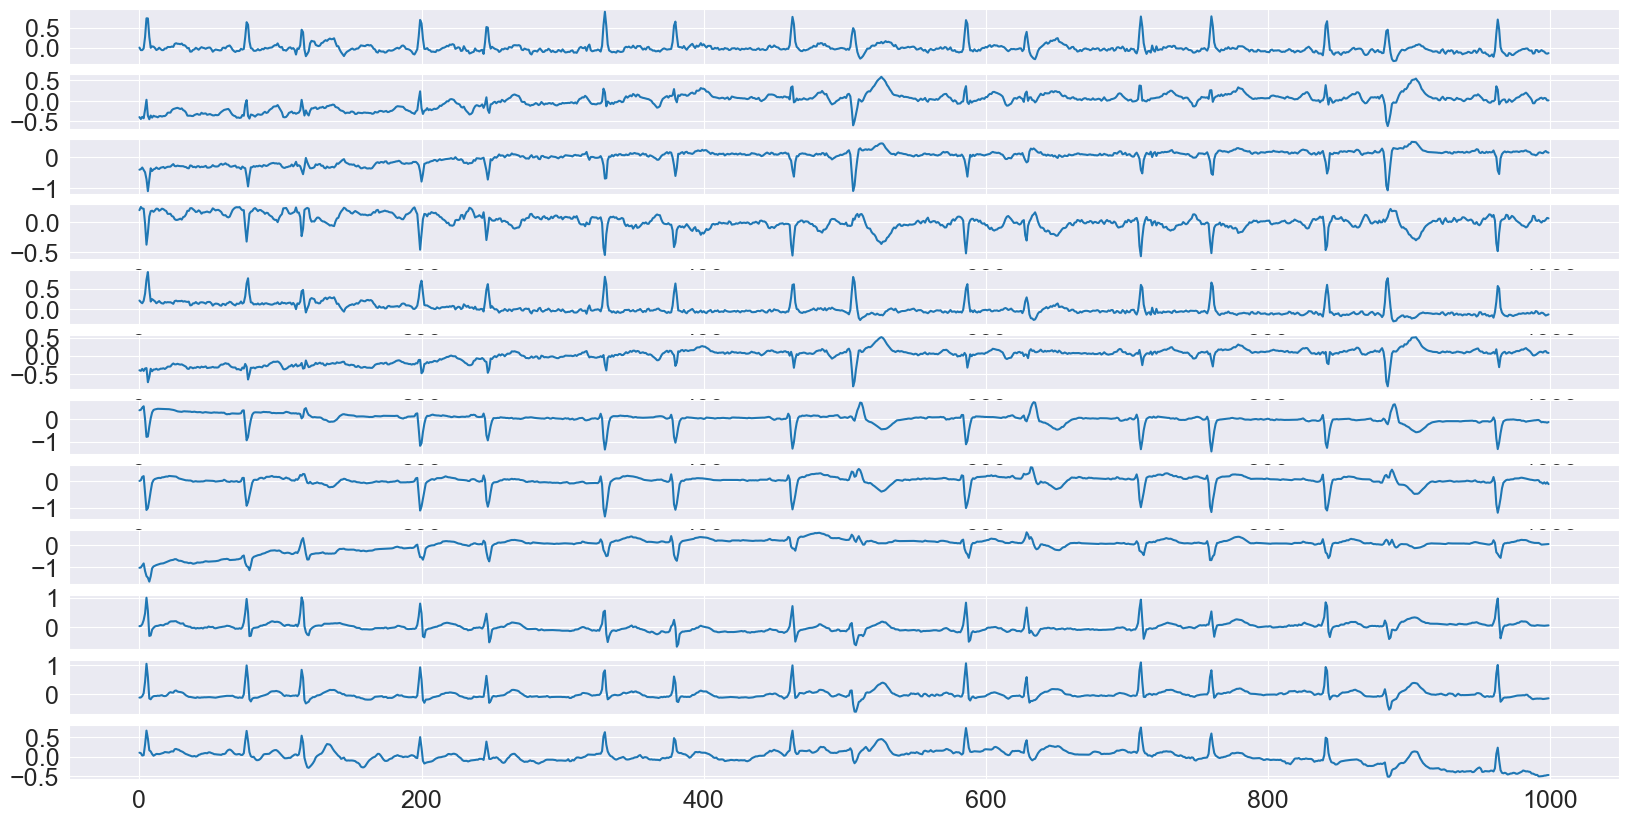

In [7]:
sample = ECG_data[0]  # Pastikan ECG_data sudah ada dalam lingkungan Anda
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(20, 10))

for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])

# Perbesar angka pada sumbu X dan Y
for ax in axes:
    ax.tick_params(axis='both', labelsize=18)  # Mengatur ukuran font untuk sumbu X dan Y

plt.show()

In [ ]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                       9228
age                                90
sex                                 2
height                             63
weight                            107
nurse                              12
site                               49
device                             11
recording_date                  10908
report                           5312
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    182
static_noise                       90
burst_noise                        73
electrodes_problems                 6
extra_beats                       100
pacemaker                           2
strat_fold                         10
filename_lr                     10919
filename_hr                     10919
dtype: int64

# Data preparation for modeling

## X dataframe (metadata)

In [ ]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

C:\Users\oc\AppData\Local\Temp\ipykernel_4472\3316299910.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X.age.fillna(0, inplace=True)
C:\Users\oc\AppData\Local\Temp\ipykernel_4472\3316299910.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
10919,74.0,0.0,0.0,0.0,0.0,0.0,0.0
10920,61.0,0.0,190.0,95.0,0.0,0.0,0.0
10921,70.0,1.0,170.0,77.0,0.0,0.0,0.0
10922,45.0,0.0,0.0,0.0,0.0,0.0,0.0
10923,74.0,0.0,178.0,71.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


## Y dataframe (raw signal)

## Z targets (target)

In [10]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
10919,0,1,0,0,0
10920,1,0,0,0,0
10921,0,0,1,0,1
10922,0,0,0,1,0
10923,0,0,1,0,1
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


## Splitting to train, validate and test datasets

As the authors of PTB-XL ECG dataset suggest, I will split all input and output dataset to training, validation and test subsets according *strat_fold* column.

In [11]:
from sklearn.model_selection import train_test_split
X_train, Y_train, Z_train = X[ECG_df.strat_fold <= 10],  ECG_data[X[ECG_df.strat_fold <= 10].index - 10919],  Z[ECG_df.strat_fold <= 10]
mask_train = (Z_train['NORM'] == 1) | (Z_train['MI'] == 1)
X_train_filtered = X_train[mask_train]
Y_train_filtered = Y_train[mask_train]
Z_train_filtered = Z_train[mask_train].drop(columns=['STTC', 'CD', 'HYP'])

X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
    X_train_filtered, Y_train_filtered, Z_train_filtered, test_size=0.1, random_state=42
)
print(X_train.shape, Y_train.shape, Z_train.shape)
print(X_test.shape,  Y_test.shape,  Z_test.shape)

(6682, 7) (6682, 1000, 12) (6682, 2)
(743, 7) (743, 1000, 12) (743, 2)


In [12]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
X_scaler = StandardScaler()

# Step 2: Fit the scaler only on the X_train data
X_scaler.fit(X_train)

# Step 3: Transform the training, validation, and test sets using the fitted scaler
X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train shape:", X_train_scaled.shape)
print("Scaled Test shape:", X_test_scaled.shape)

Scaled Train shape: (6682, 7)
Scaled Test shape: (743, 7)


In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for Y data
Y_scaler = StandardScaler()

# Step 1: Fit the scaler only on the Y_train data
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

# Step 2: Transform the training, validation, and test sets
Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_test_scaled  = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

# Check the shapes to ensure everything is scaled correctly
print("Scaled Train Y shape:", Y_train_scaled.shape)
print("Scaled Test Y shape:", Y_test_scaled.shape)


Scaled Train Y shape: (6682, 1000, 12)
Scaled Test Y shape: (743, 1000, 12)


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Prepare data
# Ensure the input is 3D (samples, timesteps, features) for LSTM

X_train = Y_train_scaled  # Using the signal data as X
X_test  = Y_test_scaled

# Z is the target (NORM, MI)
y_train = Z_train[['NORM', 'MI']].values
y_test  = Z_test[['NORM', 'MI']].values




In [15]:
from tensorflow.keras.models import load_model
# Path to your model files
lstm_model_path = 'final_lstm_model.h5'
stacked_lstm_model_path = 'final_stacked_lstm_model.h5'
bi_lstm_model_path = 'final_bi_lstm_model.h5'

In [16]:
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train,  test_size=0.2, random_state=42,  shuffle=True 
)


In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Membuat objek StratifiedKFold dengan 5 fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variabel untuk menyimpan hasil fold
folds = []

# Melakukan pembagian data ke dalam 5 fold
for train_index, val_index in kf.split(X_train, np.argmax(y_train, axis=1)):  # Pastikan menggunakan y_train, bukan y_test
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Menyimpan fold hasil pemisahan
    folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold))

    # Anda bisa melakukan pelatihan model atau evaluasi pada tiap fold disini
    # Misalnya:
    # model.fit(X_train_fold, y_train_fold)
    # model.score(X_val_fold, y_val_fold)

# Output folds (sebagai contoh)
for i, (X_train_fold, X_val_fold, y_train_fold, y_val_fold) in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"X_train_fold shape: {X_train_fold.shape}, y_train_fold shape: {y_train_fold.shape}")
    print(f"X_val_fold shape: {X_val_fold.shape}, y_val_fold shape: {y_val_fold.shape}")
    print("="*50)

Fold 1:
X_train_fold shape: (5345, 1000, 12), y_train_fold shape: (5345, 2)
X_val_fold shape: (1337, 1000, 12), y_val_fold shape: (1337, 2)
Fold 2:
X_train_fold shape: (5345, 1000, 12), y_train_fold shape: (5345, 2)
X_val_fold shape: (1337, 1000, 12), y_val_fold shape: (1337, 2)
Fold 3:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)
Fold 4:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)
Fold 5:
X_train_fold shape: (5346, 1000, 12), y_train_fold shape: (5346, 2)
X_val_fold shape: (1336, 1000, 12), y_val_fold shape: (1336, 2)


# LSTM

In [44]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [45]:
from sklearn.model_selection import ParameterGrid
# Parameter grid
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32, 64]
}

# Placeholder untuk hasil tuning
results = []

# Loop untuk setiap kombinasi hyperparameter
for params in ParameterGrid(param_grid):
    print(f"\nTraining dengan parameter: {params}")
    
    # Load ulang model awal setiap kali
    model_lstm = load_model(lstm_model_path)
    
    # Compile model dengan learning rate sesuai
    model_lstm.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model_lstm.fit(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        epochs=10,
        batch_size=params['batch_size'],
        verbose=1
    )
    
    # Simpan hasil (val_accuracy dari epoch terakhir)
    val_accuracy = history.history['val_accuracy'][-1]
    results.append({
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'val_accuracy': val_accuracy
    })

# Hasil tuning
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='val_accuracy', ascending=False)
print("\nHasil Hyperparameter Tuning:")
print(results_df)

# Parameter terbaik untuk LSTM
best_param_lstm = results_df.iloc[0].to_dict()
print(f"\nParameter terbaik untuk LSTM: {best_param_lstm}")



Training dengan parameter: {'batch_size': 16, 'learning_rate': 0.001}


Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 65s 182ms/step - accuracy: 0.8149 - loss: 0.4610 - val_accuracy: 0.8302 - val_loss: 0.3995
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 56s 166ms/step - accuracy: 0.8342 - loss: 0.4011 - val_accuracy: 0.8474 - val_loss: 0.3864
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 155ms/step - accuracy: 0.8356 - loss: 0.4070 - val_accuracy: 0.8661 - val_loss: 0.3624
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 154ms/step - accuracy: 0.8538 - loss: 0.3823 - val_accuracy: 0.8153 - val_loss: 0.4111
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 51s 153ms/step - accuracy: 0.8263 - loss: 0.4119 - val_accuracy: 0.8033 - val_loss: 0.4211
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 53s 159ms/step - accuracy: 0.8145 - loss: 0.4279 - val_accuracy: 0.8085 - val_loss: 0.4243
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - accuracy: 0.8190 - loss: 0.4089 - val_accuracy: 0.8242 - val_loss: 0.3889
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 55s 165ms/step - accuracy: 0.8434 - loss: 0


Training dengan parameter: {'batch_size': 16, 'learning_rate': 0.0001}
Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 56s 163ms/step - accuracy: 0.8181 - loss: 0.5179 - val_accuracy: 0.8355 - val_loss: 0.4215
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 79s 155ms/step - accuracy: 0.8265 - loss: 0.4526 - val_accuracy: 0.8399 - val_loss: 0.4062
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 62s 186ms/step - accuracy: 0.8180 - loss: 0.4475 - val_accuracy: 0.8377 - val_loss: 0.3909
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 70s 151ms/step - accuracy: 0.8338 - loss: 0.4169 - val_accuracy: 0.8377 - val_loss: 0.3894
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 50s 149ms/step - accuracy: 0.8339 - loss: 0.4209 - val_accuracy: 0.8384 - val_loss: 0.3921
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 50s 149ms/step - accuracy: 0.8230 - loss: 0.4273 - val_accuracy: 0.8377 - val_loss: 0.3882
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 53s 159ms/step - accuracy: 0.8294 - loss: 0.4124 - val_accuracy: 0.8407 - val_loss: 0.3848
Epoch 8/10



Training dengan parameter: {'batch_size': 32, 'learning_rate': 0.001}
Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.8353 - loss: 0.4955 - val_accuracy: 0.8399 - val_loss: 0.4114
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 38s 226ms/step - accuracy: 0.8185 - loss: 0.4615 - val_accuracy: 0.8452 - val_loss: 0.4174
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.8348 - loss: 0.4291 - val_accuracy: 0.8414 - val_loss: 0.4167
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - accuracy: 0.8251 - loss: 0.4326 - val_accuracy: 0.8168 - val_loss: 0.4290
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.7706 - loss: 0.4960 - val_accuracy: 0.7225 - val_loss: 0.5295
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 32s 192ms/step - accuracy: 0.7066 - loss: 0.5354 - val_accuracy: 0.8362 - val_loss: 0.4207
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 197ms/step - accuracy: 0.8223 - loss: 0.4368 - val_accuracy: 0.8392 - val_loss: 0.4058
Epoch 8/10
1


Training dengan parameter: {'batch_size': 32, 'learning_rate': 0.0001}
Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 186ms/step - accuracy: 0.8173 - loss: 0.4969 - val_accuracy: 0.8362 - val_loss: 0.4363
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 187ms/step - accuracy: 0.8049 - loss: 0.4970 - val_accuracy: 0.8287 - val_loss: 0.4319
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.8079 - loss: 0.4784 - val_accuracy: 0.8302 - val_loss: 0.4305
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.8106 - loss: 0.4717 - val_accuracy: 0.8384 - val_loss: 0.4207
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 32s 190ms/step - accuracy: 0.8217 - loss: 0.4683 - val_accuracy: 0.8362 - val_loss: 0.4136
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 31s 187ms/step - accuracy: 0.8208 - loss: 0.4513 - val_accuracy: 0.8340 - val_loss: 0.4051
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.8175 - loss: 0.4543 - val_accuracy: 0.8332 - val_loss: 0.4025
Epoch 8/10



Training dengan parameter: {'batch_size': 64, 'learning_rate': 0.001}
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.7546 - loss: 0.5483 - val_accuracy: 0.7726 - val_loss: 0.4733
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.7329 - loss: 0.5250 - val_accuracy: 0.7719 - val_loss: 0.4687
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.7153 - loss: 0.5341 - val_accuracy: 0.7726 - val_loss: 0.4671
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.7219 - loss: 0.5312 - val_accuracy: 0.7809 - val_loss: 0.4657
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - accuracy: 0.7255 - loss: 0.5307 - val_accuracy: 0.7846 - val_loss: 0.4627
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - accuracy: 0.7346 - loss: 0.5049 - val_accuracy: 0.7868 - val_loss: 0.4579
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 228ms/step - accuracy: 0.7414 - loss: 0.4950 - val_accuracy: 0.7883 - val_loss: 0.4553
Epoch 8/10
84/84 ━━━━━━━━━


Training dengan parameter: {'batch_size': 64, 'learning_rate': 0.0001}
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.8151 - loss: 0.5091 - val_accuracy: 0.8377 - val_loss: 0.4418
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.8224 - loss: 0.4794 - val_accuracy: 0.8355 - val_loss: 0.4353
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.8128 - loss: 0.4821 - val_accuracy: 0.8340 - val_loss: 0.4282
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.8204 - loss: 0.4699 - val_accuracy: 0.8310 - val_loss: 0.4263
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.8140 - loss: 0.4659 - val_accuracy: 0.8355 - val_loss: 0.4210
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.8108 - loss: 0.4853 - val_accuracy: 0.8287 - val_loss: 0.4185
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.8134 - loss: 0.4677 - val_accuracy: 0.8272 - val_loss: 0.4142
Epoch 8/10
84/84 ━━━━━━━━

Using Best Parameters: {'learning_rate': 0.0001, 'batch_size': 16.0, 'val_accuracy': 0.8429319262504578}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,300 (55.86 KB)

 Trainable params: 14,298 (55.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Processing Fold 1



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8278 - loss: 0.4858
Epoch 1: val_accuracy improved from -inf to 0.82274, saving model to modelResult/best_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 55s 158ms/step - accuracy: 0.8278 - loss: 0.4858 - val_accuracy: 0.8227 - val_loss: 0.4617 - learning_rate: 1.0000e-04
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8260 - loss: 0.4454
Epoch 2: val_accuracy did not improve from 0.82274
335/335 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - accuracy: 0.8260 - loss: 0.4454 - val_accuracy: 0.8220 - val_loss: 0.4449 - learning_rate: 1.0000e-04
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8253 - loss: 0.4274
Epoch 3: val_accuracy improved from 0.82274 to 0.82573, saving model to modelResult/best_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 54s 162ms/step - accuracy: 0.8253 - loss: 0.4274 - val_accuracy: 0.8257 - val_loss: 0.4275 - learning_rate: 1.0000e-04
Epoch 4/50
335/335

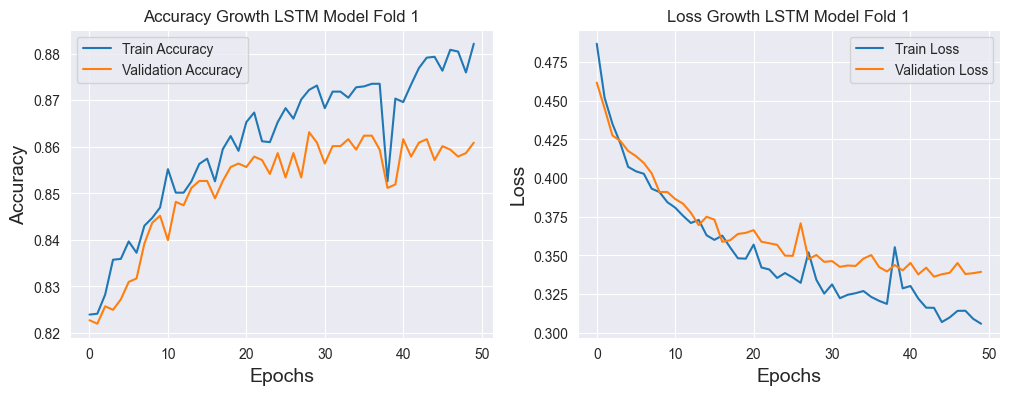

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8837 - loss: 0.3128
Test Loss: 0.32395854592323303, Test Accuracy: 0.8761776685714722
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step


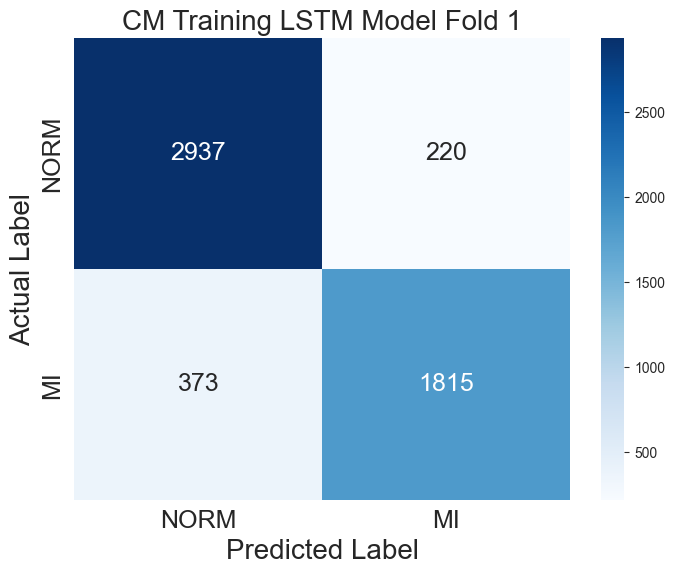

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


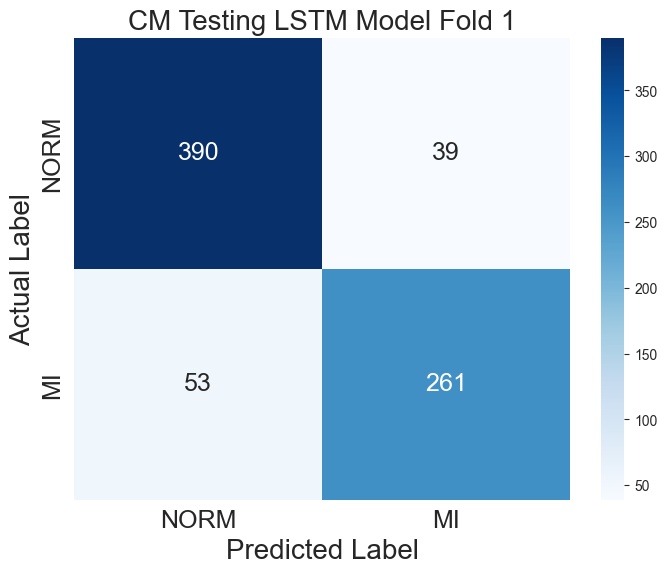


Processing Fold 2



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8098 - loss: 0.5038
Epoch 1: val_accuracy improved from -inf to 0.83844, saving model to modelResult/best_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 55s 160ms/step - accuracy: 0.8098 - loss: 0.5038 - val_accuracy: 0.8384 - val_loss: 0.4638 - learning_rate: 1.0000e-04
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8251 - loss: 0.4677
Epoch 2: val_accuracy improved from 0.83844 to 0.84144, saving model to modelResult/best_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 53s 159ms/step - accuracy: 0.8251 - loss: 0.4676 - val_accuracy: 0.8414 - val_loss: 0.4376 - learning_rate: 1.0000e-04
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8302 - loss: 0.4426
Epoch 3: val_accuracy did not improve from 0.84144
335/335 ━━━━━━━━━━━━━━━━━━━━ 54s 160ms/step - accuracy: 0.8301 - loss: 0.4426 - val_accuracy: 0.8369 - val_loss: 0.4264 - learning_rate: 1.0000e-04
Epoch 4/50
335/335

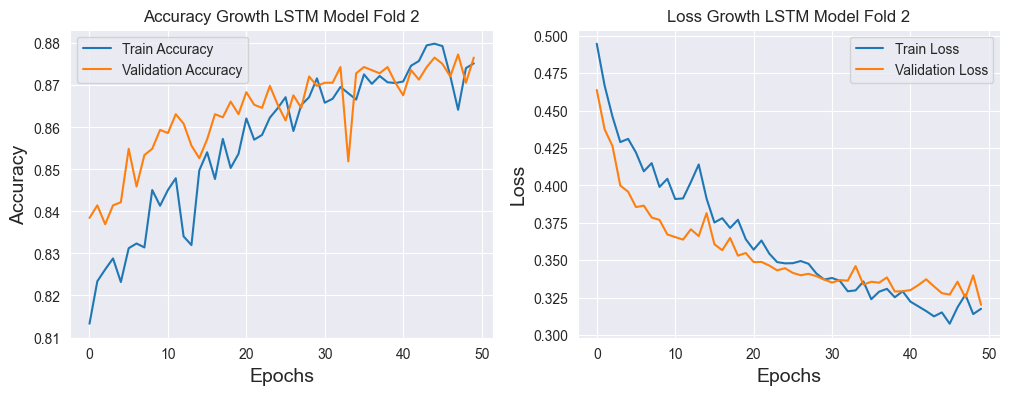

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8691 - loss: 0.3173
Test Loss: 0.32218384742736816, Test Accuracy: 0.8734858632087708
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step


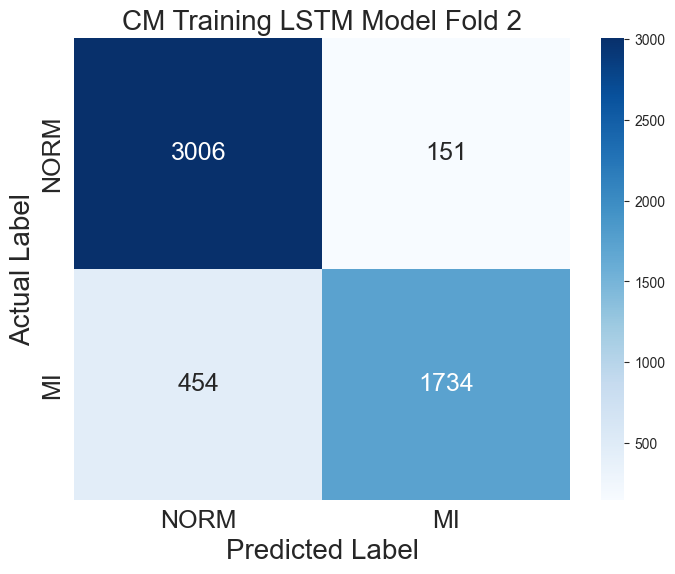

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


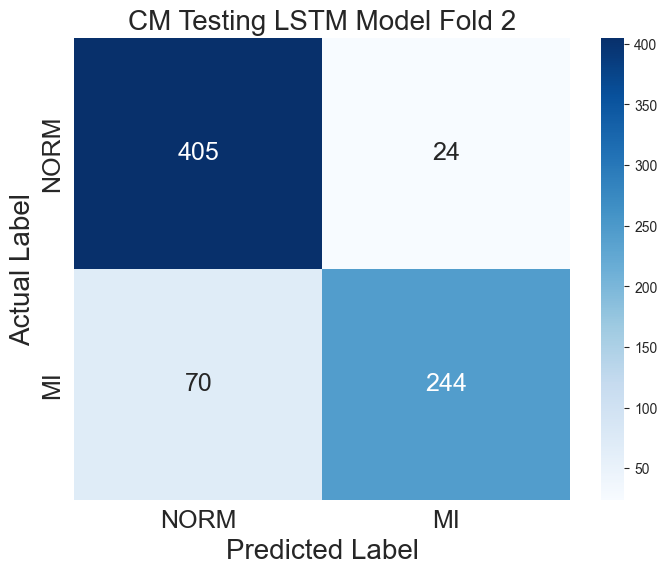


Processing Fold 3



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8103 - loss: 0.5160
Epoch 1: val_accuracy improved from -inf to 0.82635, saving model to modelResult/best_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 51s 147ms/step - accuracy: 0.8103 - loss: 0.5159 - val_accuracy: 0.8263 - val_loss: 0.4282 - learning_rate: 1.0000e-04
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8191 - loss: 0.4615
Epoch 2: val_accuracy improved from 0.82635 to 0.83383, saving model to modelResult/best_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 50s 150ms/step - accuracy: 0.8191 - loss: 0.4615 - val_accuracy: 0.8338 - val_loss: 0.4110 - learning_rate: 1.0000e-04
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8210 - loss: 0.4433
Epoch 3: val_accuracy improved from 0.83383 to 0.83608, saving model to modelResult/best_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 50s 150ms/step - accuracy: 0.8209 - loss: 0.4433 - val_accuracy: 0.8361 - v

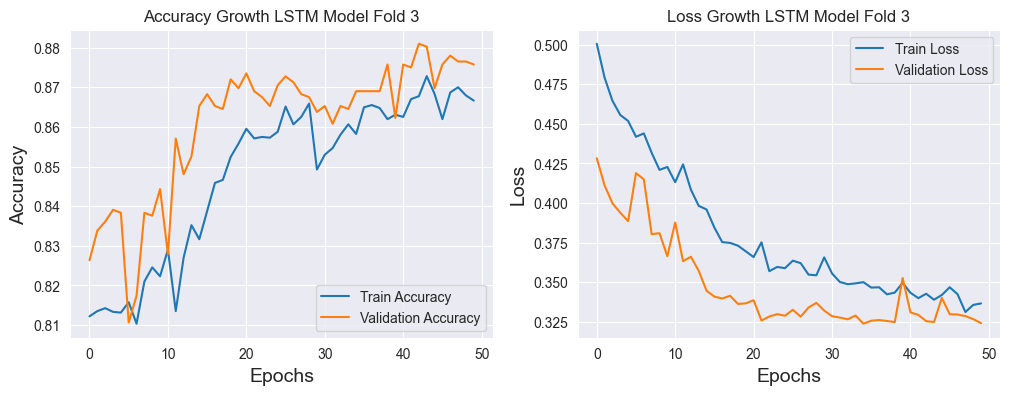

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8670 - loss: 0.3430
Test Loss: 0.35313597321510315, Test Accuracy: 0.8573351502418518
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step


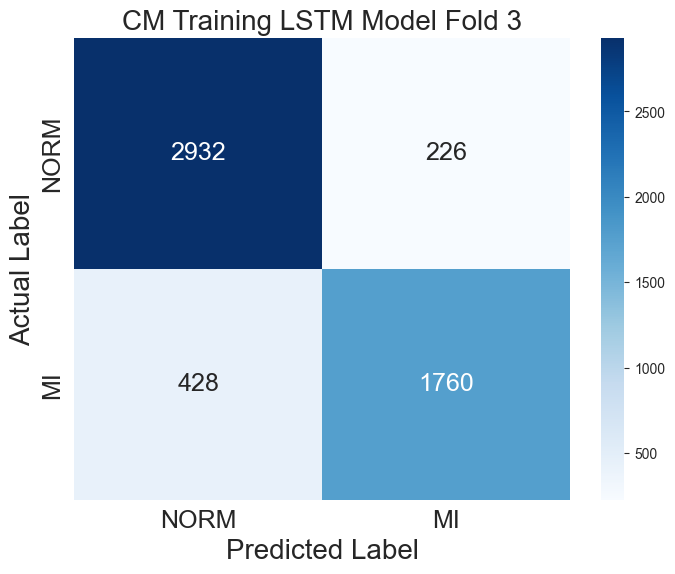

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


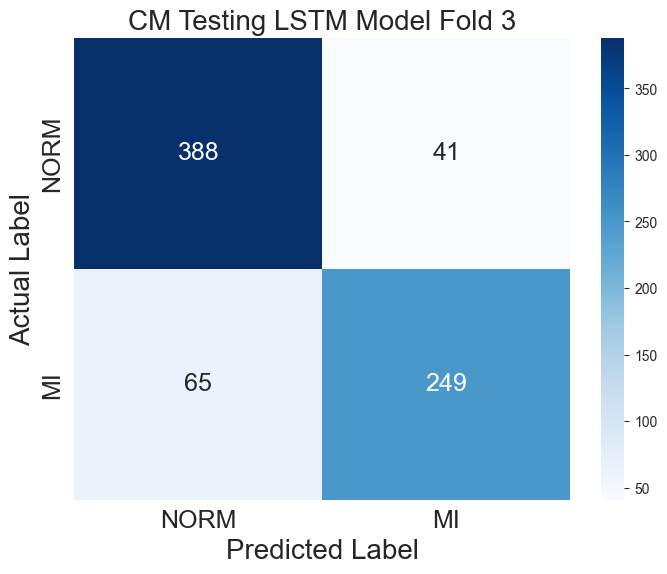


Processing Fold 4



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8192 - loss: 0.5203
Epoch 1: val_accuracy improved from -inf to 0.83159, saving model to modelResult/best_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - accuracy: 0.8192 - loss: 0.5203 - val_accuracy: 0.8316 - val_loss: 0.4567 - learning_rate: 1.0000e-04
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8288 - loss: 0.4763
Epoch 2: val_accuracy improved from 0.83159 to 0.83308, saving model to modelResult/best_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - accuracy: 0.8288 - loss: 0.4763 - val_accuracy: 0.8331 - val_loss: 0.4432 - learning_rate: 1.0000e-04
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8255 - loss: 0.4601
Epoch 3: val_accuracy did not improve from 0.83308
335/335 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - accuracy: 0.8255 - loss: 0.4601 - val_accuracy: 0.8323 - val_loss: 0.4321 - learning_rate: 1.0000e-04
Epoch 4/50
335/335

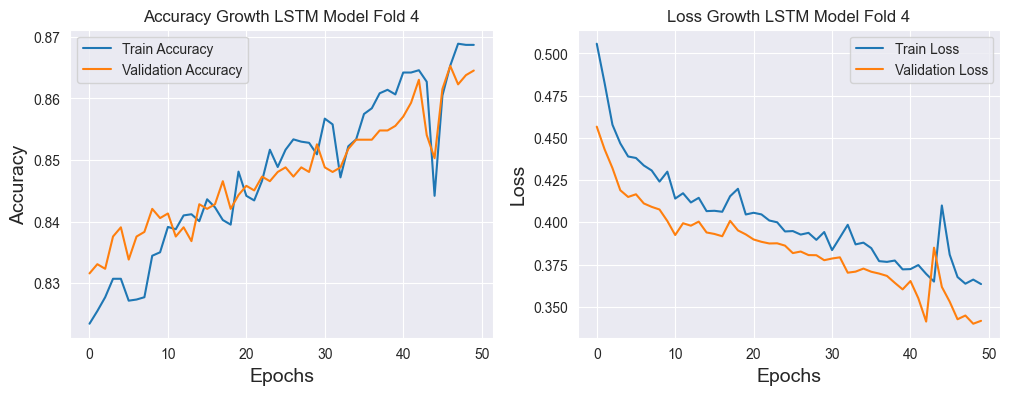

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8629 - loss: 0.3703
Test Loss: 0.38290730118751526, Test Accuracy: 0.8532974720001221
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step


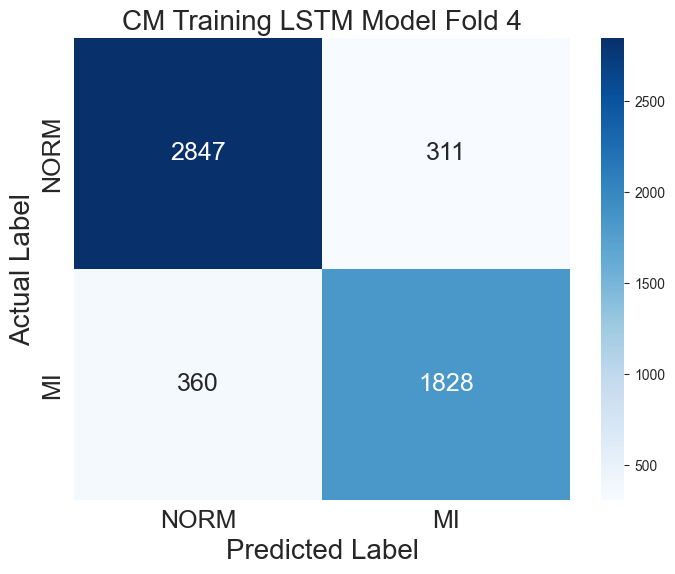

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


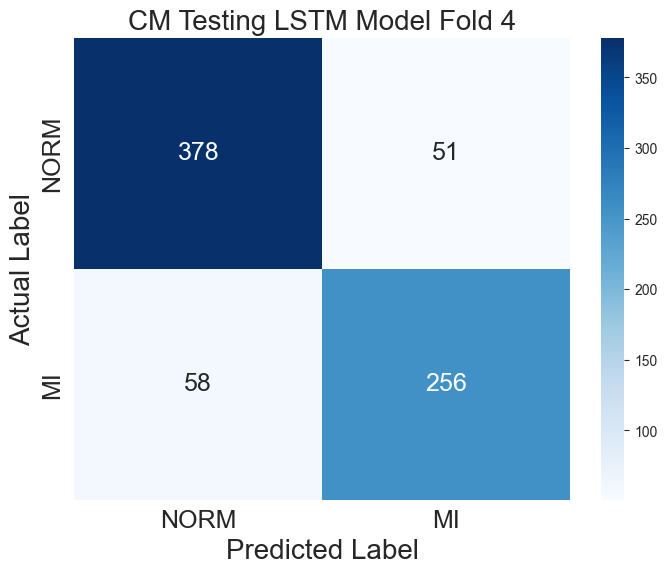


Processing Fold 5



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8222 - loss: 0.4851
Epoch 1: val_accuracy improved from -inf to 0.83683, saving model to modelResult/best_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.8221 - loss: 0.4851 - val_accuracy: 0.8368 - val_loss: 0.4625 - learning_rate: 1.0000e-04
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8275 - loss: 0.4659
Epoch 2: val_accuracy improved from 0.83683 to 0.83757, saving model to modelResult/best_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 43s 129ms/step - accuracy: 0.8275 - loss: 0.4659 - val_accuracy: 0.8376 - val_loss: 0.4388 - learning_rate: 1.0000e-04
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8320 - loss: 0.4455
Epoch 3: val_accuracy did not improve from 0.83757
335/335 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.8320 - loss: 0.4454 - val_accuracy: 0.8316 - val_loss: 0.4214 - learning_rate: 1.0000e-04
Epoch 4/50
335/335

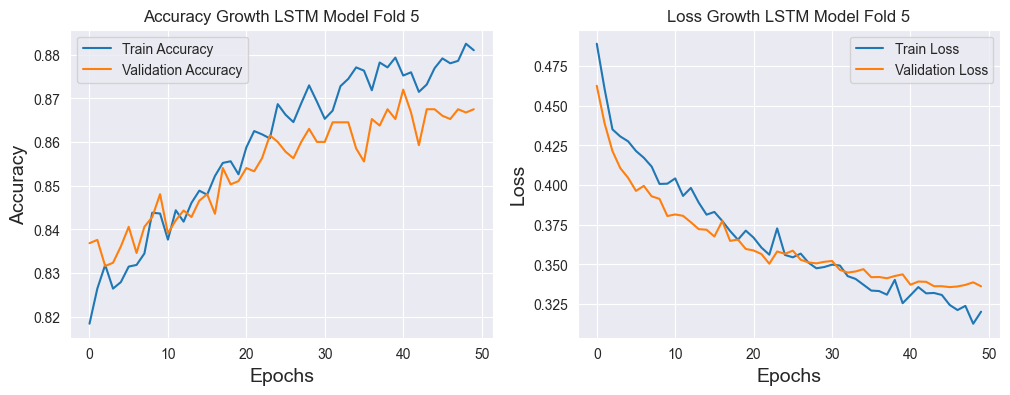

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8830 - loss: 0.3168
Test Loss: 0.3321739733219147, Test Accuracy: 0.8734858632087708
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step


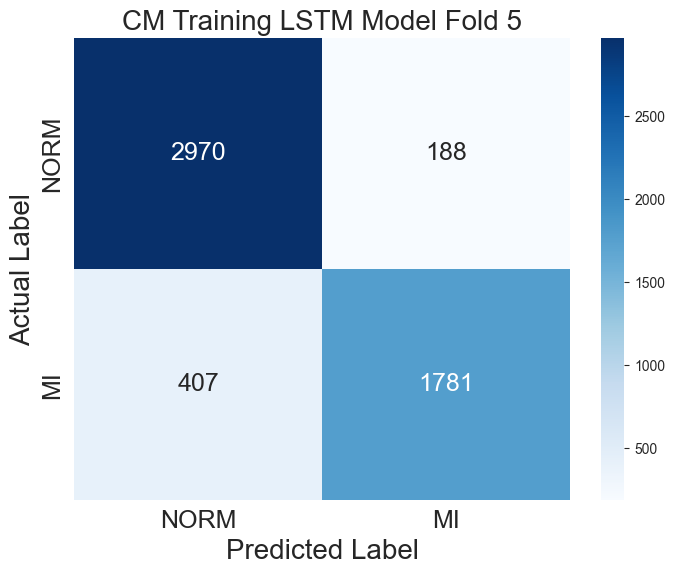

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


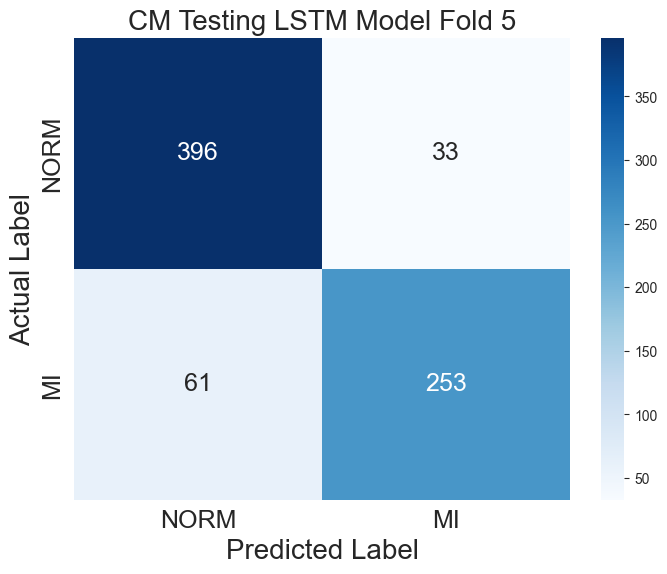


Cross-Validation Metrics Summary:
   fold  test_loss  test_accuracy
0     1   0.323959       0.876178
1     2   0.322184       0.873486
2     3   0.353136       0.857335
3     4   0.382907       0.853297
4     5   0.332174       0.873486

Average Validation Accuracy across all folds: 0.8668


In [46]:
# Placeholder untuk hasil fold
fold_metrics = []

# Step 1: Define Cross-Validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0

# Load the pretrained LSTM model path
print("Using Best Parameters:", best_param_lstm)
learning_rate = best_param_lstm['learning_rate']
batch_size = int(best_param_lstm['batch_size'])

pretrained_lstm_model = load_model(lstm_model_path)
pretrained_lstm_model.summary()

# Loop untuk setiap fold
for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_lstm_model = load_model(lstm_model_path)

    pretrained_lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), 
                                  loss='categorical_crossentropy', 
                                  metrics=['accuracy'])
    
    # Step 5: Define Callbacks
    checkpoint = ModelCheckpoint(filepath=f'modelResult/best_lstm_model_fold_{fold}.keras', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 verbose=1, 
                                 mode='max')


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=10, 
                                  min_lr=0.000001, 
                                  verbose=1)

    # Step 6: Fine-tuning the new model on the current fold's training set
    history = pretrained_lstm_model.fit(X_train_fold, y_train_fold, 
                        epochs=50, 
                        batch_size=batch_size, 
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=[checkpoint, reduce_lr], 
                        verbose=1)

    # Step 7: Plot accuracy and loss for the current fold
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Growth LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Growth LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.savefig(f'image/training_history_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Step 8: Evaluate model on the test set
    test_loss, test_accuracy = pretrained_lstm_model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Save fold metrics
    fold_metrics.append({
        "fold": fold,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
    })

    # Step 9: Confusion Matrix on the training set
    y_train_pred = pretrained_lstm_model.predict(X_train_fold)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true_classes = np.argmax(y_train_fold, axis=1)
    
    cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for training as CSV
    cm_train_df = pd.DataFrame(cm_train, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_train_df.to_csv(f'excel_output/confusion_matrix_training_lstm_model_fold_{fold}.csv')

    # Step 9: Confusion Matrix on the test set
    y_test_pred = pretrained_lstm_model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true_classes = np.argmax(y_test, axis=1)
    
    cm_test = confusion_matrix(y_test_true_classes, y_test_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot test confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Testing LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_testing_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for testing as CSV
    cm_test_df = pd.DataFrame(cm_test, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_test_df.to_csv(f'excel_output/confusion_matrix_testing_lstm_model_fold_{fold}.csv')

# Step 10: Save the metrics summary
metrics_df = pd.DataFrame(fold_metrics)
metrics_df.to_csv('excel_output/fold_metrics_summary_lstm_model.csv', index=False)

# Print out the summary of the metrics across all folds
print("\nCross-Validation Metrics Summary:")
print(metrics_df)

# Calculate and print the average accuracy across all folds
mean_accuracy = metrics_df['test_accuracy'].mean()
print(f"\nAverage Validation Accuracy across all folds: {mean_accuracy:.4f}")

# STACKED LSTM

In [47]:
from sklearn.model_selection import ParameterGrid
# Parameter grid
param_grid_stacked_lstm = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32, 64]
}


# Placeholder untuk hasil tuning
results_stacked_lstm = []

# Loop untuk setiap kombinasi hyperparameter
for params in ParameterGrid(param_grid_stacked_lstm):
    print(f"\nTraining dengan parameter: {params}")
    
    # Load ulang model untuk setiap kombinasi
    model_stacked_lstm = load_model(stacked_lstm_model_path)
    
    # Compile model dengan learning rate yang sesuai
    model_stacked_lstm.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Split data untuk training dan validasi sementara
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Train model
    history = model_stacked_lstm.fit(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        epochs=10,  
        batch_size=params['batch_size'],
        verbose=1
    )
    
    # Simpan hasil (val_accuracy dari epoch terakhir)
    val_accuracy = history.history['val_accuracy'][-1]
    results_stacked_lstm.append({
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'val_accuracy': val_accuracy
    })

# Hasil tuning
results_df_stacked_lstm = pd.DataFrame(results_stacked_lstm)
results_df_stacked_lstm = results_df_stacked_lstm.sort_values(by='val_accuracy', ascending=False)
print("\nHasil Hyperparameter Tuning Stacked LSTM:")
print(results_df_stacked_lstm)

# Simpan parameter terbaik untuk Stacked LSTM
best_param_stacked_lstm = results_df_stacked_lstm.iloc[0].to_dict()
print(f"\nParameter terbaik untuk Stacked LSTM: {best_param_stacked_lstm}")


Training dengan parameter: {'batch_size': 16, 'learning_rate': 0.001}
Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 115s 337ms/step - accuracy: 0.8510 - loss: 0.3603 - val_accuracy: 0.8190 - val_loss: 0.3898
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 116s 346ms/step - accuracy: 0.8430 - loss: 0.3759 - val_accuracy: 0.8743 - val_loss: 0.3191
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 113s 338ms/step - accuracy: 0.8543 - loss: 0.3486 - val_accuracy: 0.8706 - val_loss: 0.3027
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 114s 340ms/step - accuracy: 0.8720 - loss: 0.3171 - val_accuracy: 0.8758 - val_loss: 0.3987
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 113s 337ms/step - accuracy: 0.8857 - loss: 0.3204 - val_accuracy: 0.8833 - val_loss: 0.2847
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 114s 340ms/step - accuracy: 0.8598 - loss: 0.3256 - val_accuracy: 0.8085 - val_loss: 0.3526
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 113s 337ms/step - accuracy: 0.8778 - loss: 0.2951 - val_accuracy: 0.8960 - val_loss: 0.2617
Epoch


Training dengan parameter: {'batch_size': 16, 'learning_rate': 0.0001}
Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 116s 341ms/step - accuracy: 0.8369 - loss: 0.4258 - val_accuracy: 0.8639 - val_loss: 0.3328
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 114s 341ms/step - accuracy: 0.8517 - loss: 0.3379 - val_accuracy: 0.8579 - val_loss: 0.3209
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 115s 342ms/step - accuracy: 0.8540 - loss: 0.3362 - val_accuracy: 0.8631 - val_loss: 0.3048
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 115s 342ms/step - accuracy: 0.8535 - loss: 0.3254 - val_accuracy: 0.8624 - val_loss: 0.3085
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 114s 340ms/step - accuracy: 0.8610 - loss: 0.3153 - val_accuracy: 0.8624 - val_loss: 0.3003
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 114s 340ms/step - accuracy: 0.8708 - loss: 0.2998 - val_accuracy: 0.8669 - val_loss: 0.2928
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 114s 341ms/step - accuracy: 0.8687 - loss: 0.2976 - val_accuracy: 0.8639 - val_loss: 0.2973
Epoc


Training dengan parameter: {'batch_size': 32, 'learning_rate': 0.001}
Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 71s 413ms/step - accuracy: 0.8384 - loss: 0.3870 - val_accuracy: 0.8489 - val_loss: 0.3093
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 412ms/step - accuracy: 0.8617 - loss: 0.3330 - val_accuracy: 0.8542 - val_loss: 0.3499
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 412ms/step - accuracy: 0.8711 - loss: 0.3234 - val_accuracy: 0.8624 - val_loss: 0.3537
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 71s 421ms/step - accuracy: 0.8429 - loss: 0.3797 - val_accuracy: 0.8736 - val_loss: 0.3184
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 70s 414ms/step - accuracy: 0.8791 - loss: 0.3129 - val_accuracy: 0.8721 - val_loss: 0.3052
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 70s 414ms/step - accuracy: 0.8772 - loss: 0.2796 - val_accuracy: 0.8908 - val_loss: 0.2673
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 413ms/step - accuracy: 0.8908 - loss: 0.2711 - val_accuracy: 0.8990 - val_loss: 0.2601
Epoch 8/10
1


Training dengan parameter: {'batch_size': 32, 'learning_rate': 0.0001}
Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 71s 411ms/step - accuracy: 0.8471 - loss: 0.4108 - val_accuracy: 0.8609 - val_loss: 0.3246
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 413ms/step - accuracy: 0.8530 - loss: 0.3514 - val_accuracy: 0.8661 - val_loss: 0.3223
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 412ms/step - accuracy: 0.8493 - loss: 0.3418 - val_accuracy: 0.8512 - val_loss: 0.3138
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 70s 415ms/step - accuracy: 0.8578 - loss: 0.3260 - val_accuracy: 0.8684 - val_loss: 0.3132
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 413ms/step - accuracy: 0.8638 - loss: 0.3326 - val_accuracy: 0.8669 - val_loss: 0.3065
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 414ms/step - accuracy: 0.8674 - loss: 0.3037 - val_accuracy: 0.8706 - val_loss: 0.3063
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 411ms/step - accuracy: 0.8773 - loss: 0.3032 - val_accuracy: 0.8728 - val_loss: 0.3003
Epoch 8/10



Training dengan parameter: {'batch_size': 64, 'learning_rate': 0.001}
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 954ms/step - accuracy: 0.8359 - loss: 0.3825 - val_accuracy: 0.8340 - val_loss: 0.3440
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 970ms/step - accuracy: 0.8436 - loss: 0.3375 - val_accuracy: 0.8631 - val_loss: 0.3380
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 76s 905ms/step - accuracy: 0.8491 - loss: 0.3476 - val_accuracy: 0.8639 - val_loss: 0.3260
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 76s 905ms/step - accuracy: 0.8640 - loss: 0.3317 - val_accuracy: 0.8781 - val_loss: 0.2892
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 75s 891ms/step - accuracy: 0.8853 - loss: 0.2944 - val_accuracy: 0.8414 - val_loss: 0.3763
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 76s 908ms/step - accuracy: 0.8672 - loss: 0.3523 - val_accuracy: 0.8743 - val_loss: 0.3109
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 76s 909ms/step - accuracy: 0.8773 - loss: 0.3248 - val_accuracy: 0.8886 - val_loss: 0.2779
Epoch 8/10
84/84 ━━━━━━━━━


Training dengan parameter: {'batch_size': 64, 'learning_rate': 0.0001}
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 951ms/step - accuracy: 0.8449 - loss: 0.4226 - val_accuracy: 0.8601 - val_loss: 0.3328
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 79s 945ms/step - accuracy: 0.8467 - loss: 0.3603 - val_accuracy: 0.8631 - val_loss: 0.3248
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 951ms/step - accuracy: 0.8522 - loss: 0.3366 - val_accuracy: 0.8542 - val_loss: 0.3193
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 954ms/step - accuracy: 0.8550 - loss: 0.3335 - val_accuracy: 0.8646 - val_loss: 0.3138
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 949ms/step - accuracy: 0.8554 - loss: 0.3259 - val_accuracy: 0.8654 - val_loss: 0.3111
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 955ms/step - accuracy: 0.8564 - loss: 0.3399 - val_accuracy: 0.8624 - val_loss: 0.3103
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 952ms/step - accuracy: 0.8600 - loss: 0.3135 - val_accuracy: 0.8639 - val_loss: 0.3155
Epoch 8/10
84/84 ━━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1000, 100)      │        45,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1000, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,796 (307.80 KB)

 Trainable params: 78,794 (307.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Processing Fold 1



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8317 - loss: 0.4026
Epoch 1: val_accuracy improved from -inf to 0.85415, saving model to modelResult/best_stacked_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 135s 398ms/step - accuracy: 0.8318 - loss: 0.4025 - val_accuracy: 0.8542 - val_loss: 0.3580 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8667 - loss: 0.3379
Epoch 2: val_accuracy did not improve from 0.85415
335/335 ━━━━━━━━━━━━━━━━━━━━ 125s 374ms/step - accuracy: 0.8667 - loss: 0.3379 - val_accuracy: 0.8512 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8425 - loss: 0.3772
Epoch 3: val_accuracy improved from 0.85415 to 0.86313, saving model to modelResult/best_stacked_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 125s 375ms/step - accuracy: 0.8425 - loss: 0.3771 - val_accuracy: 0.8631 - val_loss: 0.3211 - learning_rate: 0.0010
Epoch 4/50


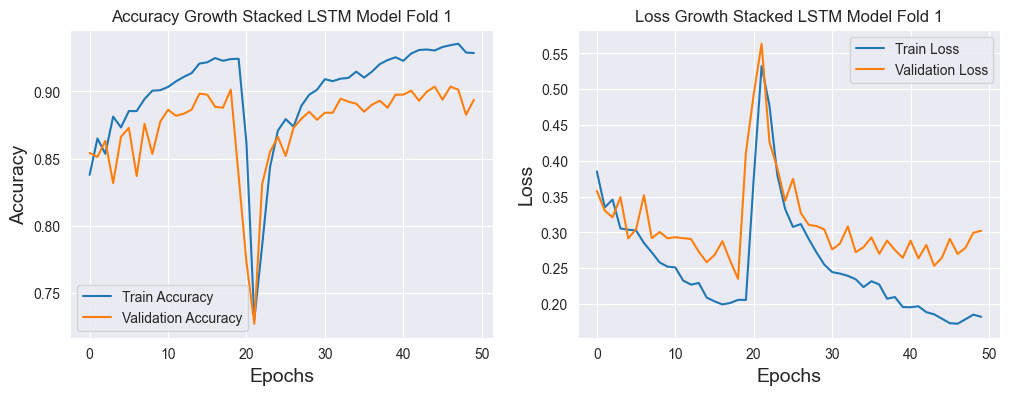

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8796 - loss: 0.2836
Test Loss: 0.29117822647094727, Test Accuracy: 0.8869448304176331
168/168 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step


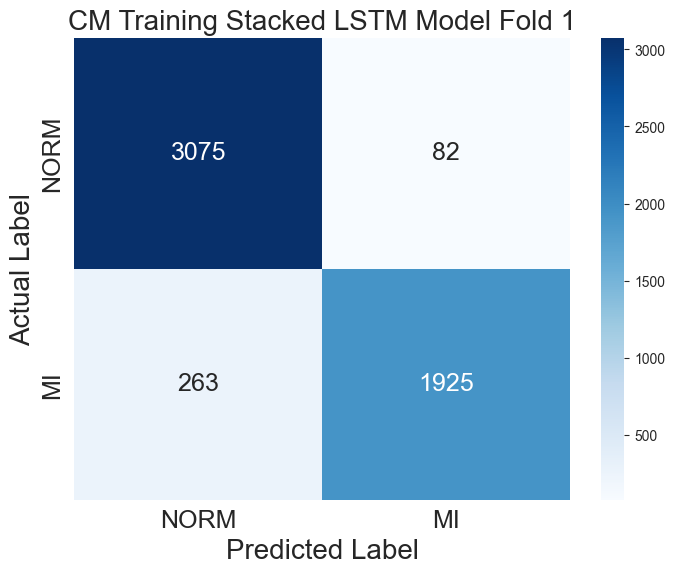

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step


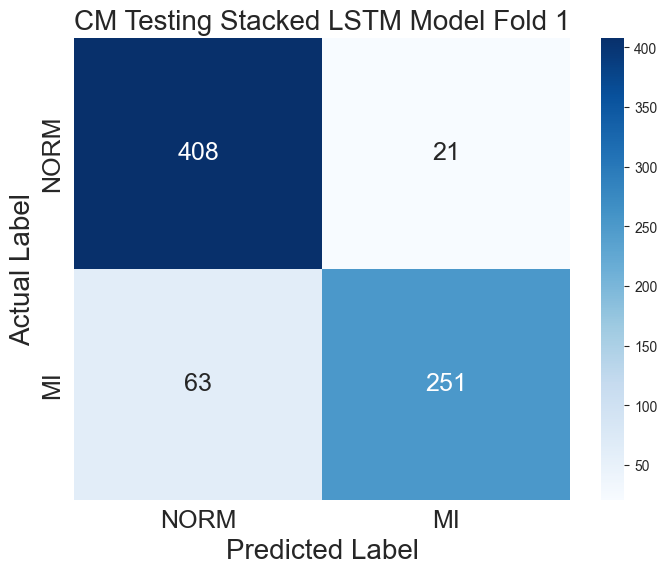


Processing Fold 2



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8481 - loss: 0.3742
Epoch 1: val_accuracy improved from -inf to 0.87659, saving model to modelResult/best_stacked_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 125s 368ms/step - accuracy: 0.8481 - loss: 0.3742 - val_accuracy: 0.8766 - val_loss: 0.3378 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8567 - loss: 0.3431
Epoch 2: val_accuracy improved from 0.87659 to 0.87734, saving model to modelResult/best_stacked_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 120s 358ms/step - accuracy: 0.8567 - loss: 0.3432 - val_accuracy: 0.8773 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8649 - loss: 0.3287
Epoch 3: val_accuracy improved from 0.87734 to 0.89155, saving model to modelResult/best_stacked_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 119s 356ms/step - accuracy: 0.8649 - loss: 0.3287 - val_a

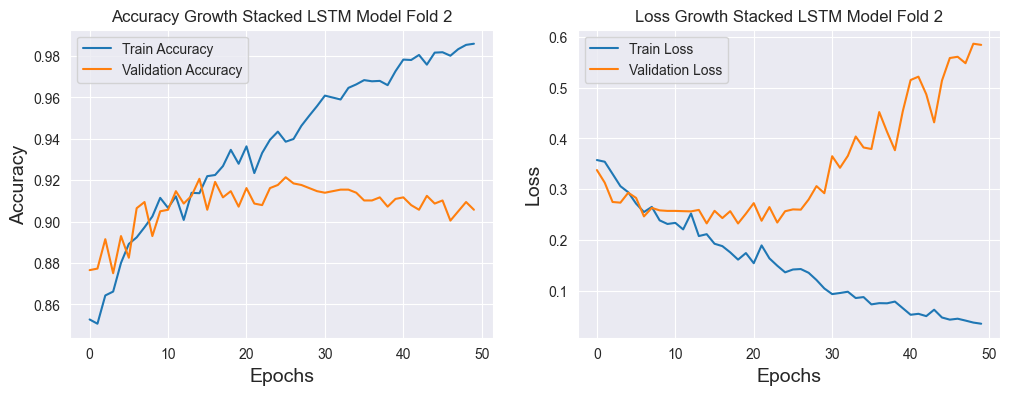

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.8936 - loss: 0.6714
Test Loss: 0.6182888150215149, Test Accuracy: 0.9057873487472534
168/168 ━━━━━━━━━━━━━━━━━━━━ 23s 136ms/step


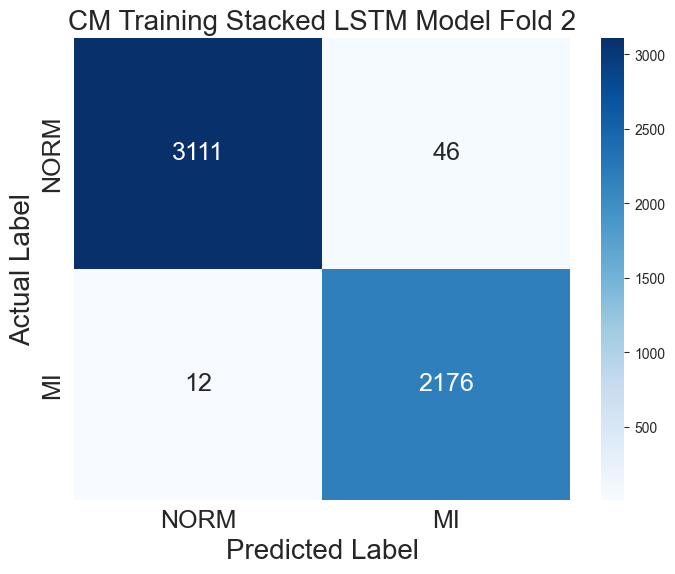

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step


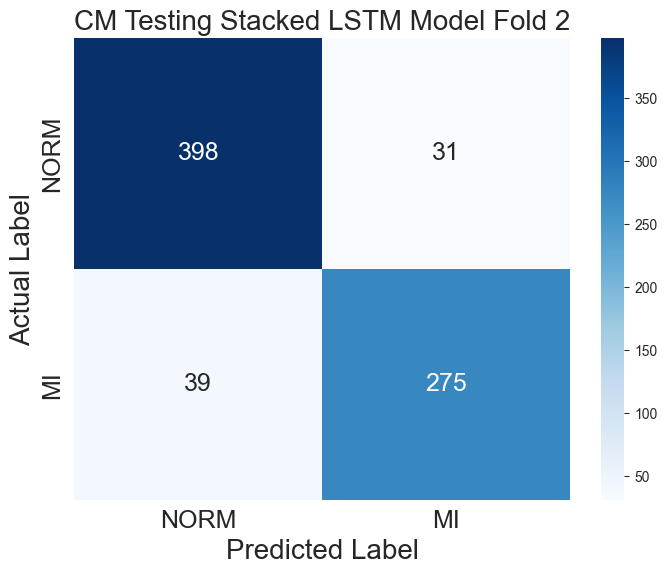


Processing Fold 3



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8304 - loss: 0.3891
Epoch 1: val_accuracy improved from -inf to 0.86452, saving model to modelResult/best_stacked_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 133s 392ms/step - accuracy: 0.8304 - loss: 0.3891 - val_accuracy: 0.8645 - val_loss: 0.3342 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8614 - loss: 0.3568
Epoch 2: val_accuracy improved from 0.86452 to 0.87126, saving model to modelResult/best_stacked_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 127s 379ms/step - accuracy: 0.8614 - loss: 0.3567 - val_accuracy: 0.8713 - val_loss: 0.3203 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8530 - loss: 0.3434
Epoch 3: val_accuracy did not improve from 0.87126
335/335 ━━━━━━━━━━━━━━━━━━━━ 124s 371ms/step - accuracy: 0.8530 - loss: 0.3434 - val_accuracy: 0.8540 - val_loss: 0.3275 - learning_rate: 0.0010
Epoch 4/50


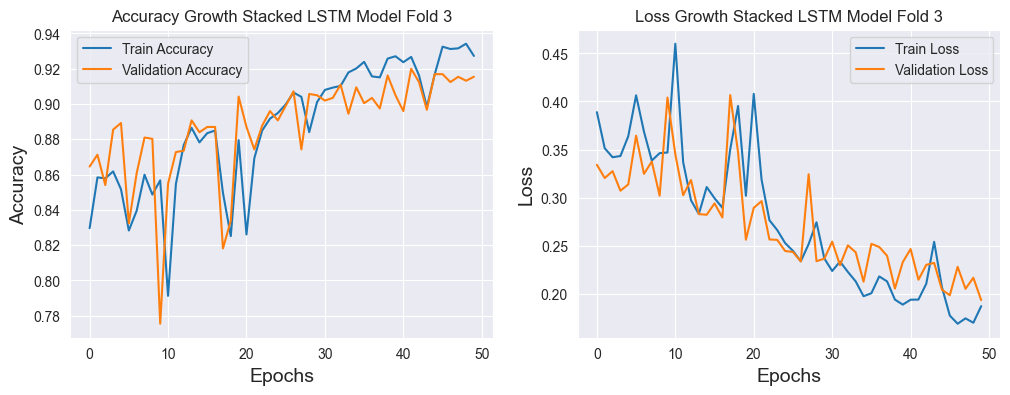

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9192 - loss: 0.2149
Test Loss: 0.2110213041305542, Test Accuracy: 0.920592188835144
168/168 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step


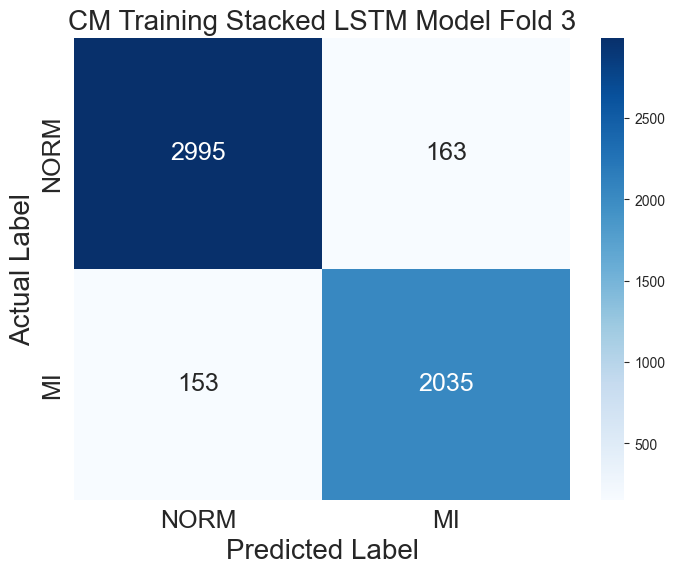

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step


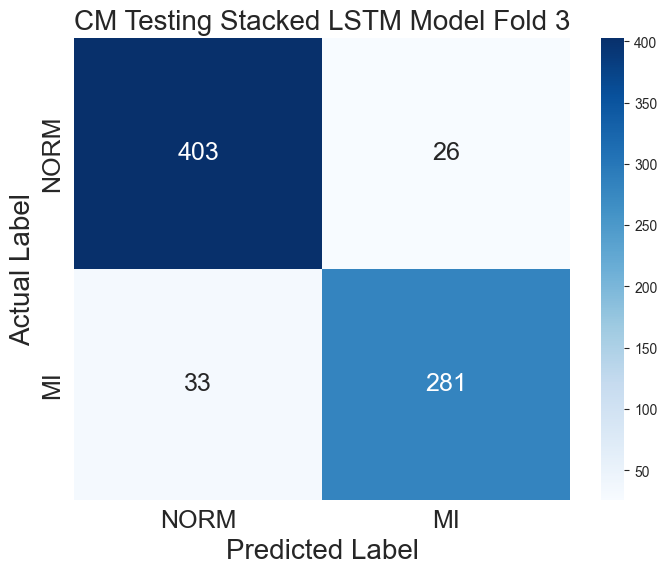


Processing Fold 4



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8302 - loss: 0.3993
Epoch 1: val_accuracy improved from -inf to 0.87575, saving model to modelResult/best_stacked_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 130s 382ms/step - accuracy: 0.8302 - loss: 0.3992 - val_accuracy: 0.8757 - val_loss: 0.3001 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8472 - loss: 0.3592
Epoch 2: val_accuracy did not improve from 0.87575
335/335 ━━━━━━━━━━━━━━━━━━━━ 123s 368ms/step - accuracy: 0.8472 - loss: 0.3592 - val_accuracy: 0.8728 - val_loss: 0.2844 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8474 - loss: 0.3562
Epoch 3: val_accuracy improved from 0.87575 to 0.88772, saving model to modelResult/best_stacked_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 123s 366ms/step - accuracy: 0.8474 - loss: 0.3563 - val_accuracy: 0.8877 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 4/50


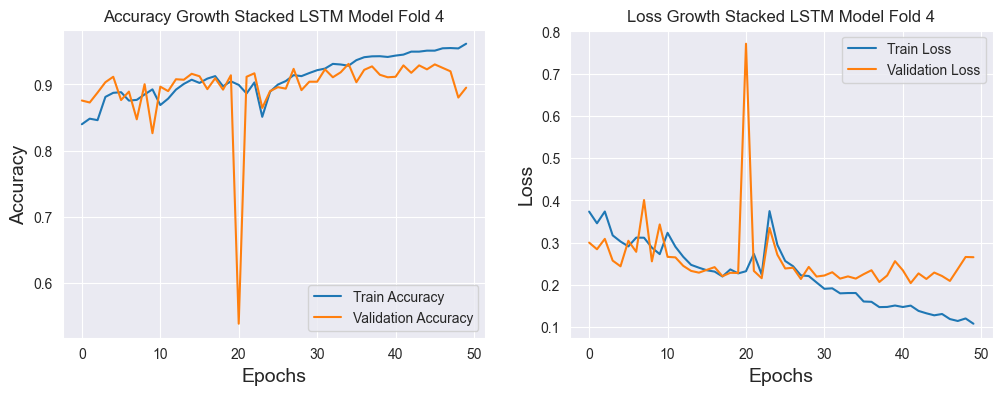

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9010 - loss: 0.2697
Test Loss: 0.26397672295570374, Test Accuracy: 0.9017496705055237
168/168 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step


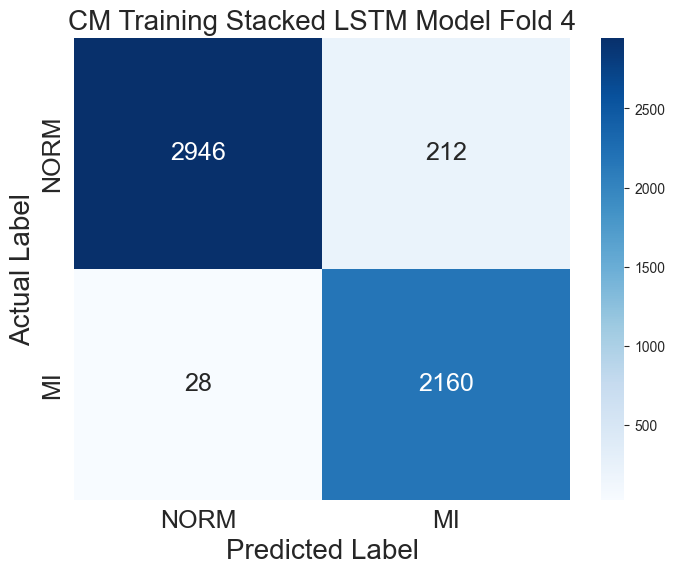

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step


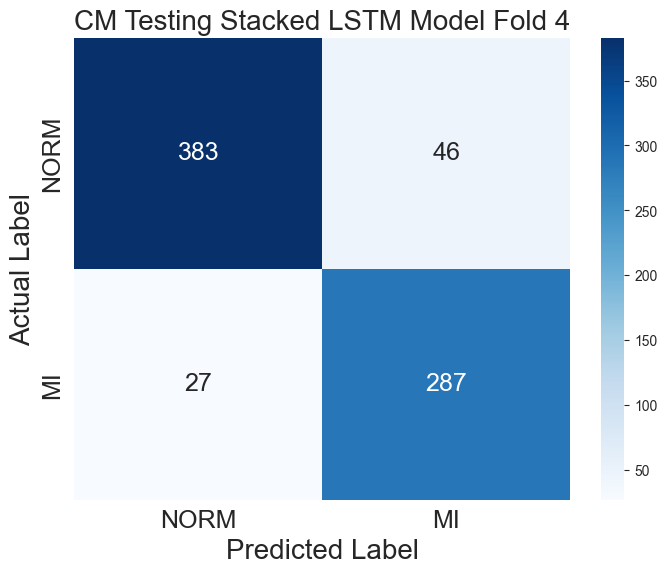


Processing Fold 5



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8417 - loss: 0.3842
Epoch 1: val_accuracy improved from -inf to 0.86377, saving model to modelResult/best_stacked_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 133s 390ms/step - accuracy: 0.8417 - loss: 0.3841 - val_accuracy: 0.8638 - val_loss: 0.3314 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8591 - loss: 0.3538
Epoch 2: val_accuracy improved from 0.86377 to 0.87350, saving model to modelResult/best_stacked_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 127s 380ms/step - accuracy: 0.8591 - loss: 0.3538 - val_accuracy: 0.8735 - val_loss: 0.3162 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8778 - loss: 0.2993
Epoch 3: val_accuracy did not improve from 0.87350
335/335 ━━━━━━━━━━━━━━━━━━━━ 127s 381ms/step - accuracy: 0.8778 - loss: 0.2993 - val_accuracy: 0.8705 - val_loss: 0.3375 - learning_rate: 0.0010
Epoch 4/50


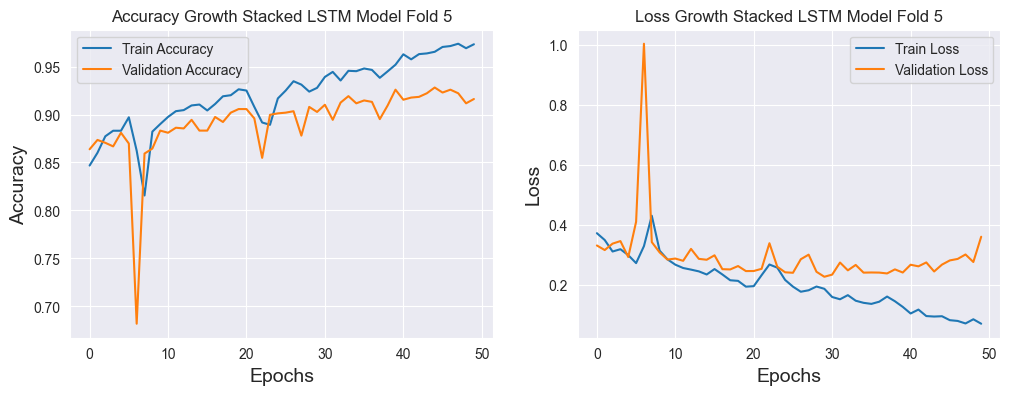

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9063 - loss: 0.3858
Test Loss: 0.4043440818786621, Test Accuracy: 0.9044414758682251
168/168 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step


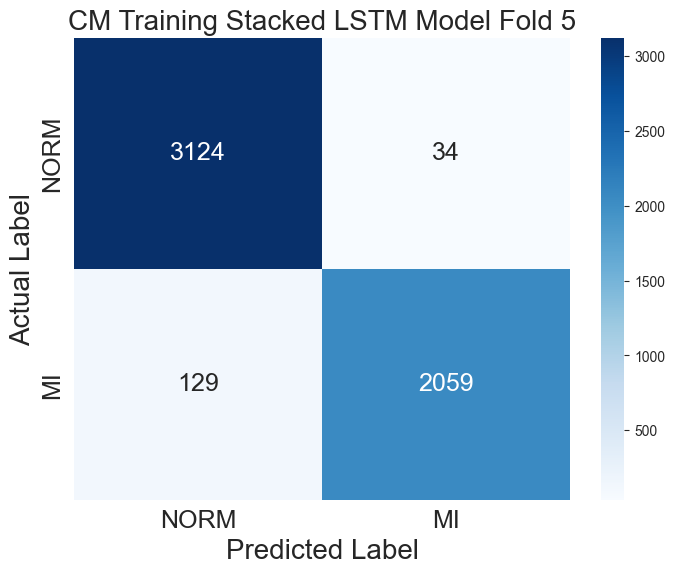

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


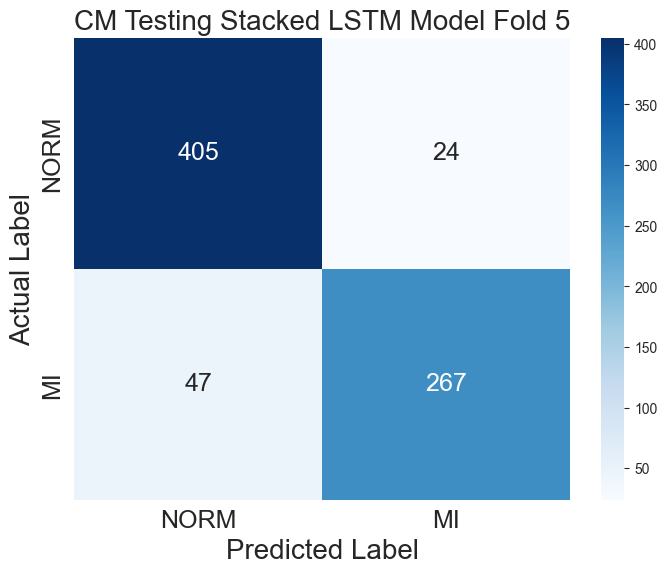


Cross-Validation Metrics Summary:
   fold  test_loss  test_accuracy
0     1   0.291178       0.886945
1     2   0.618289       0.905787
2     3   0.211021       0.920592
3     4   0.263977       0.901750
4     5   0.404344       0.904441

Average Validation Accuracy across all folds: 0.9039


In [48]:
# Placeholder untuk hasil fold
fold_metrics = []

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0

# Load the pretrained Stacked LSTM model
pretrained_stacked_lstm_model = load_model(stacked_lstm_model_path)
pretrained_stacked_lstm_model.summary()

# Gunakan parameter terbaik
learning_rate = best_param_stacked_lstm['learning_rate']
batch_size = int(best_param_stacked_lstm['batch_size'])

# Loop untuk setiap fold
for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_stacked_lstm_model = load_model(stacked_lstm_model_path)

    pretrained_stacked_lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), 
                                          loss='categorical_crossentropy', 
                                          metrics=['accuracy'])
    
    # Step 5: Define Callbacks
    checkpoint = ModelCheckpoint(filepath=f'modelResult/best_stacked_lstm_model_fold_{fold}.keras', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 verbose=1, 
                                 mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=10, 
                                  min_lr=0.000001, 
                                  verbose=1)

    # Step 6: Fine-tuning the new model on the current fold's training set
    history = pretrained_stacked_lstm_model.fit(X_train_fold, y_train_fold, 
                        epochs=50, 
                        batch_size=batch_size, 
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=[checkpoint, reduce_lr], 
                        verbose=1)

    # Step 7: Plot accuracy and loss for the current fold
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Growth Stacked LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Growth Stacked LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.savefig(f'image/training_history_stacked_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Step 8: Evaluate model on the test set
    test_loss, test_accuracy = pretrained_stacked_lstm_model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Save fold metrics
    fold_metrics.append({
        "fold": fold,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
    })

    # Step 9: Confusion Matrix on the training set
    y_train_pred = pretrained_stacked_lstm_model.predict(X_train_fold)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true_classes = np.argmax(y_train_fold, axis=1)
    
    cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training Stacked LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_stacked_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for training as CSV
    cm_train_df = pd.DataFrame(cm_train, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_train_df.to_csv(f'excel_output/confusion_matrix_training_stacked_lstm_model_fold_{fold}.csv')

    # Step 9: Confusion Matrix on the test set
    y_test_pred = pretrained_stacked_lstm_model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true_classes = np.argmax(y_test, axis=1)
    
    cm_test = confusion_matrix(y_test_true_classes, y_test_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot test confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Testing Stacked LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_testing_stacked_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for testing as CSV
    cm_test_df = pd.DataFrame(cm_test, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_test_df.to_csv(f'excel_output/confusion_matrix_testing_stacked_lstm_model_fold_{fold}.csv')

# Step 10: Save the metrics summary
metrics_df = pd.DataFrame(fold_metrics)
metrics_df.to_csv('excel_output/fold_metrics_summary_stacked_lstm_model.csv', index=False)

# Print out the summary of the metrics across all folds
print("\nCross-Validation Metrics Summary:")
print(metrics_df)

# Calculate and print the average accuracy across all folds
mean_accuracy = metrics_df['test_accuracy'].mean()
print(f"\nAverage Validation Accuracy across all folds: {mean_accuracy:.4f}")

# BI LSTM

In [18]:
from sklearn.model_selection import ParameterGrid
# Parameter grid
param_grid_bi_lstm = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [16, 32, 64]
}


# Placeholder untuk hasil tuning
results_bi_lstm = []

# Loop untuk setiap kombinasi hyperparameter
for params in ParameterGrid(param_grid_bi_lstm):
    print(f"\nTraining dengan parameter: {params}")
    
    # Load ulang model untuk setiap kombinasi
    model_bi_lstm = load_model(bi_lstm_model_path)
    
    # Compile model dengan learning rate yang sesuai
    model_bi_lstm.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Split data untuk training dan validasi sementara
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Train model
    history = model_bi_lstm.fit(
        X_train_split, y_train_split,
        validation_data=(X_val_split, y_val_split),
        epochs=10,  
        batch_size=params['batch_size'],
        verbose=1
    )
    
    # Simpan hasil (val_accuracy dari epoch terakhir)
    val_accuracy = history.history['val_accuracy'][-1]
    results_bi_lstm.append({
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'val_accuracy': val_accuracy
    })

# Hasil tuning
results_df_bi_lstm = pd.DataFrame(results_bi_lstm)
results_df_bi_lstm = results_df_bi_lstm.sort_values(by='val_accuracy', ascending=False)
print("\nHasil Hyperparameter Tuning Bi-LSTM:")
print(results_df_bi_lstm)

# Simpan parameter terbaik untuk Bi-LSTM
best_param_bi_lstm = results_df_bi_lstm.iloc[0].to_dict()
print(f"\nParameter terbaik untuk Bi-LSTM: {best_param_bi_lstm}")


Training dengan parameter: {'batch_size': 16, 'learning_rate': 0.001}


Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 189s 549ms/step - accuracy: 0.7967 - loss: 0.4686 - val_accuracy: 0.8399 - val_loss: 0.3887
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 168s 501ms/step - accuracy: 0.8380 - loss: 0.4051 - val_accuracy: 0.8138 - val_loss: 0.4152
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 168s 502ms/step - accuracy: 0.8105 - loss: 0.4161 - val_accuracy: 0.8272 - val_loss: 0.3890
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 167s 499ms/step - accuracy: 0.8331 - loss: 0.3893 - val_accuracy: 0.8340 - val_loss: 0.4014
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 168s 502ms/step - accuracy: 0.8552 - loss: 0.3584 - val_accuracy: 0.8497 - val_loss: 0.3520
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 185s 552ms/step - accuracy: 0.8600 - loss: 0.3378 - val_accuracy: 0.8556 - val_loss: 0.3433
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 185s 551ms/step - accuracy: 0.8667 - loss: 0.3327 - val_accuracy: 0.8549 - val_loss: 0.3494
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 177s 530ms/step - accuracy: 0.8665 -


Training dengan parameter: {'batch_size': 16, 'learning_rate': 0.0001}
Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 200s 582ms/step - accuracy: 0.8096 - loss: 0.4875 - val_accuracy: 0.8272 - val_loss: 0.3950
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 187s 558ms/step - accuracy: 0.8243 - loss: 0.4005 - val_accuracy: 0.8362 - val_loss: 0.3888
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 189s 563ms/step - accuracy: 0.8327 - loss: 0.3873 - val_accuracy: 0.8384 - val_loss: 0.3840
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 188s 560ms/step - accuracy: 0.8408 - loss: 0.3882 - val_accuracy: 0.8392 - val_loss: 0.3758
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 192s 573ms/step - accuracy: 0.8402 - loss: 0.3687 - val_accuracy: 0.8377 - val_loss: 0.3815
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 188s 563ms/step - accuracy: 0.8519 - loss: 0.3566 - val_accuracy: 0.8369 - val_loss: 0.3761
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 194s 579ms/step - accuracy: 0.8509 - loss: 0.3555 - val_accuracy: 0.8429 - val_loss: 0.3691
Epoc


Training dengan parameter: {'batch_size': 32, 'learning_rate': 0.001}
Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.8311 - loss: 0.4440 - val_accuracy: 0.8347 - val_loss: 0.4051
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8526 - loss: 0.3777 - val_accuracy: 0.8616 - val_loss: 0.3572
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8501 - loss: 0.3572 - val_accuracy: 0.8145 - val_loss: 0.4677
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7853 - loss: 0.4610 - val_accuracy: 0.8302 - val_loss: 0.3830
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8373 - loss: 0.3829 - val_accuracy: 0.8108 - val_loss: 0.4241
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8309 - loss: 0.4033 - val_accuracy: 0.8235 - val_loss: 0.4240
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8482 - loss: 0.3737 - val_accuracy: 0.8601 - val_loss: 0.3337
Epoch 8/10
168/168 ━━━━━━━


Training dengan parameter: {'batch_size': 32, 'learning_rate': 0.0001}
Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.8078 - loss: 0.4919 - val_accuracy: 0.8280 - val_loss: 0.4028
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.8094 - loss: 0.4429 - val_accuracy: 0.8242 - val_loss: 0.3938
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.8196 - loss: 0.4131 - val_accuracy: 0.8280 - val_loss: 0.3932
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.8247 - loss: 0.4076 - val_accuracy: 0.8272 - val_loss: 0.3950
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.8366 - loss: 0.3853 - val_accuracy: 0.8295 - val_loss: 0.3950
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.8436 - loss: 0.3848 - val_accuracy: 0.8325 - val_loss: 0.3885
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.8390 - loss: 0.3806 - val_accuracy: 0.8332 - val_loss: 0.3897
Epoch 8/10
168/168 ━━━━━━


Training dengan parameter: {'batch_size': 64, 'learning_rate': 0.001}
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.8238 - loss: 0.4361 - val_accuracy: 0.8355 - val_loss: 0.3863
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 431s 5s/step - accuracy: 0.8311 - loss: 0.3912 - val_accuracy: 0.8534 - val_loss: 0.3732
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - accuracy: 0.8373 - loss: 0.3890 - val_accuracy: 0.8227 - val_loss: 0.3956
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 450s 5s/step - accuracy: 0.8287 - loss: 0.4147 - val_accuracy: 0.8512 - val_loss: 0.3549
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - accuracy: 0.8508 - loss: 0.3681 - val_accuracy: 0.8497 - val_loss: 0.3535
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - accuracy: 0.8497 - loss: 0.3558 - val_accuracy: 0.8684 - val_loss: 0.3469
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 443s 5s/step - accuracy: 0.8621 - loss: 0.3401 - val_accuracy: 0.8601 - val_loss: 0.3349
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 44


Training dengan parameter: {'batch_size': 64, 'learning_rate': 0.0001}
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - accuracy: 0.8152 - loss: 0.4978 - val_accuracy: 0.8235 - val_loss: 0.4145
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 433s 5s/step - accuracy: 0.8239 - loss: 0.4196 - val_accuracy: 0.8250 - val_loss: 0.4019
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.8188 - loss: 0.4293 - val_accuracy: 0.8265 - val_loss: 0.3936
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 429s 5s/step - accuracy: 0.8218 - loss: 0.4163 - val_accuracy: 0.8280 - val_loss: 0.3891
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 437s 5s/step - accuracy: 0.8323 - loss: 0.3984 - val_accuracy: 0.8295 - val_loss: 0.3862
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 430s 5s/step - accuracy: 0.8355 - loss: 0.3987 - val_accuracy: 0.8257 - val_loss: 0.3886
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 428s 5s/step - accuracy: 0.8277 - loss: 0.4066 - val_accuracy: 0.8272 - val_loss: 0.3851
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 4

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1000, 200)      │        90,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1000, 200)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,396 (771.08 KB)

 Trainable params: 197,394 (771.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Processing Fold 1



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8120 - loss: 0.4480
Epoch 1: val_accuracy improved from -inf to 0.83470, saving model to modelResult/best_bi_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 495s 1s/step - accuracy: 0.8120 - loss: 0.4479 - val_accuracy: 0.8347 - val_loss: 0.4050 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8401 - loss: 0.3843
Epoch 2: val_accuracy did not improve from 0.83470
335/335 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.8401 - loss: 0.3843 - val_accuracy: 0.8325 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8575 - loss: 0.3507
Epoch 3: val_accuracy improved from 0.83470 to 0.84667, saving model to modelResult/best_bi_lstm_model_fold_1.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.8575 - loss: 0.3507 - val_accuracy: 0.8467 - val_loss: 0.3775 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━

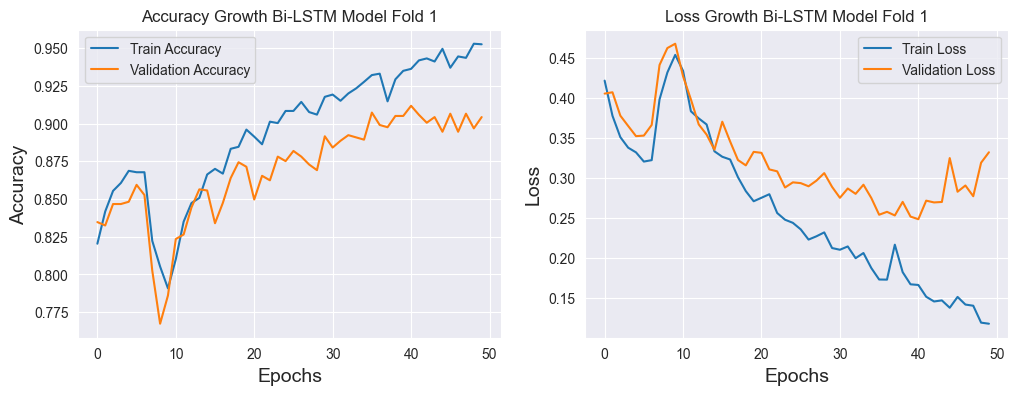

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.8903 - loss: 0.2814
Test Loss: 0.28918036818504333, Test Accuracy: 0.903095543384552
168/168 ━━━━━━━━━━━━━━━━━━━━ 77s 458ms/step


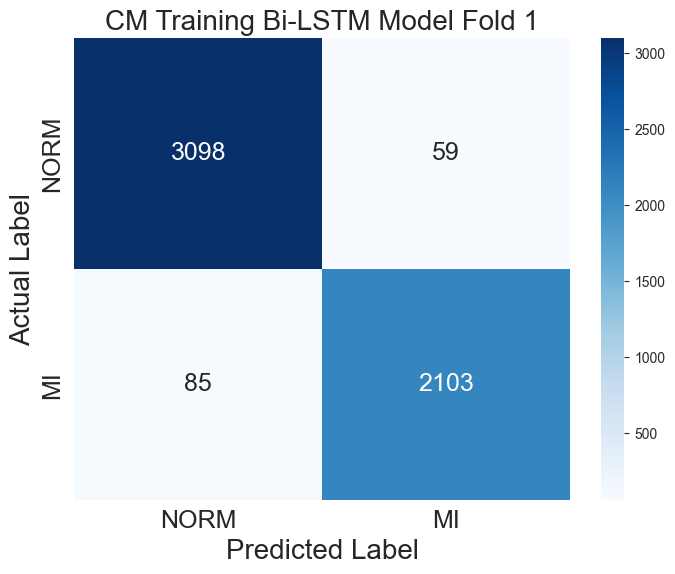

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step


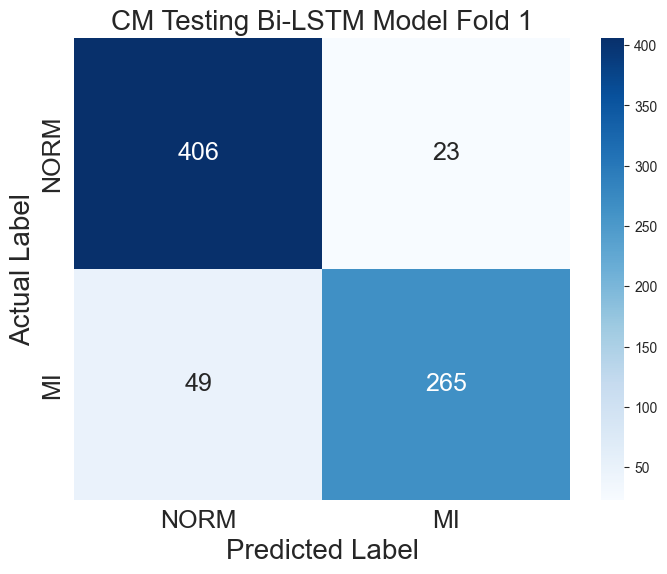


Processing Fold 2



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8114 - loss: 0.4468
Epoch 1: val_accuracy improved from -inf to 0.85939, saving model to modelResult/best_bi_lstm_model_fold_2.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.8114 - loss: 0.4468 - val_accuracy: 0.8594 - val_loss: 0.3512 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8317 - loss: 0.4121
Epoch 2: val_accuracy did not improve from 0.85939
335/335 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.8317 - loss: 0.4121 - val_accuracy: 0.8542 - val_loss: 0.3606 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8534 - loss: 0.3668
Epoch 3: val_accuracy did not improve from 0.85939
335/335 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.8533 - loss: 0.3668 - val_accuracy: 0.8571 - val_loss: 0.3456 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8459 - loss: 0.3599
Epoch 4: val_accura

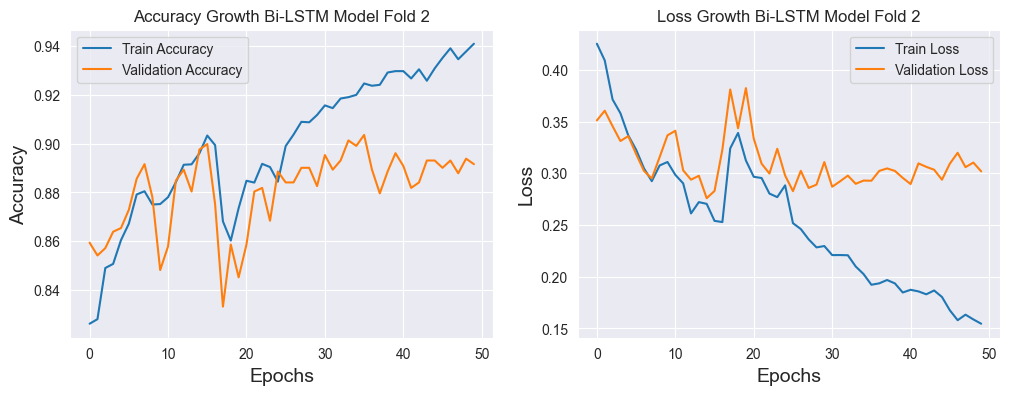

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.8842 - loss: 0.3101
Test Loss: 0.30845552682876587, Test Accuracy: 0.88559889793396
168/168 ━━━━━━━━━━━━━━━━━━━━ 69s 409ms/step


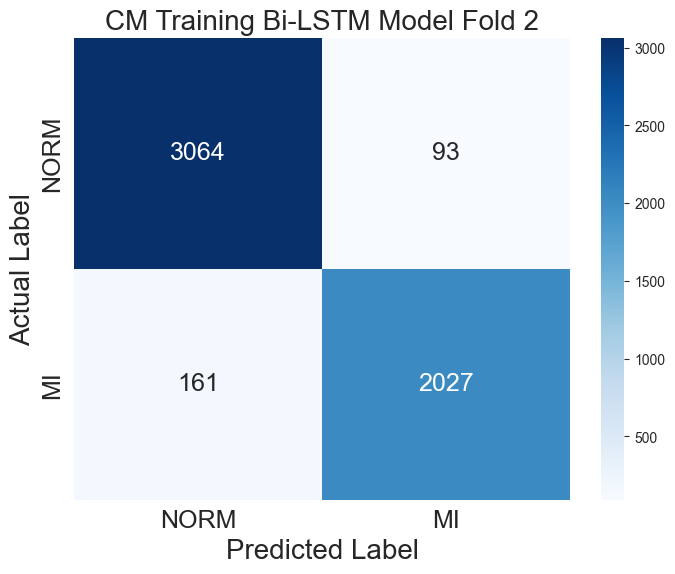

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step


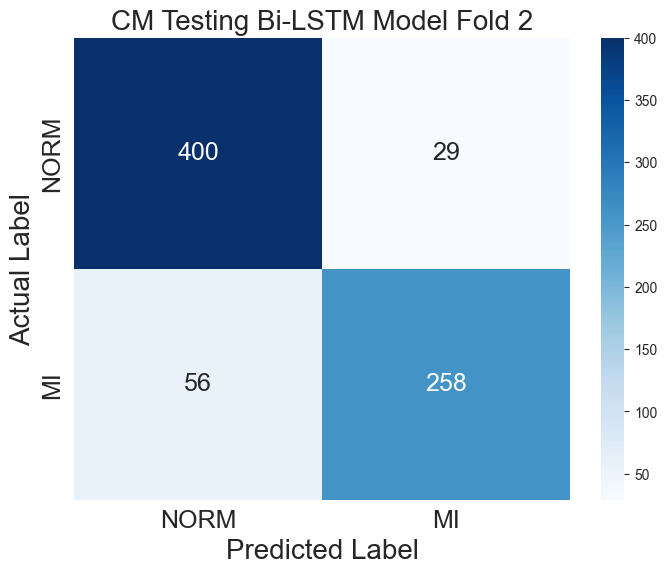


Processing Fold 3



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7971 - loss: 0.4585
Epoch 1: val_accuracy improved from -inf to 0.86602, saving model to modelResult/best_bi_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.7972 - loss: 0.4584 - val_accuracy: 0.8660 - val_loss: 0.3484 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8206 - loss: 0.4187
Epoch 2: val_accuracy did not improve from 0.86602
335/335 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.8207 - loss: 0.4186 - val_accuracy: 0.8563 - val_loss: 0.3525 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8520 - loss: 0.3622
Epoch 3: val_accuracy improved from 0.86602 to 0.87350, saving model to modelResult/best_bi_lstm_model_fold_3.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.8520 - loss: 0.3622 - val_accuracy: 0.8735 - val_loss: 0.3241 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━

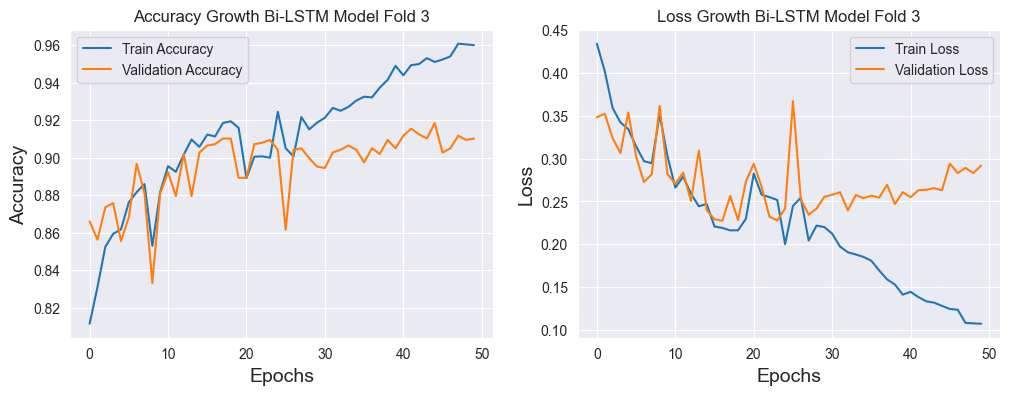

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - accuracy: 0.8911 - loss: 0.3015
Test Loss: 0.3080502152442932, Test Accuracy: 0.903095543384552
168/168 ━━━━━━━━━━━━━━━━━━━━ 79s 466ms/step


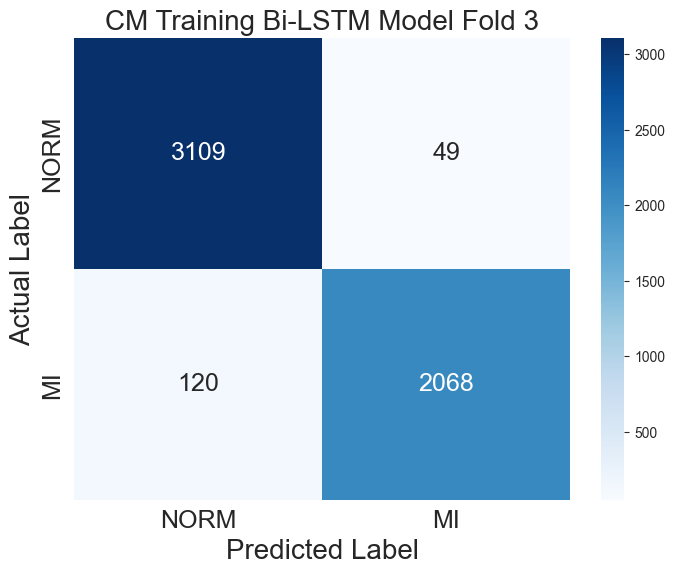

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 520ms/step


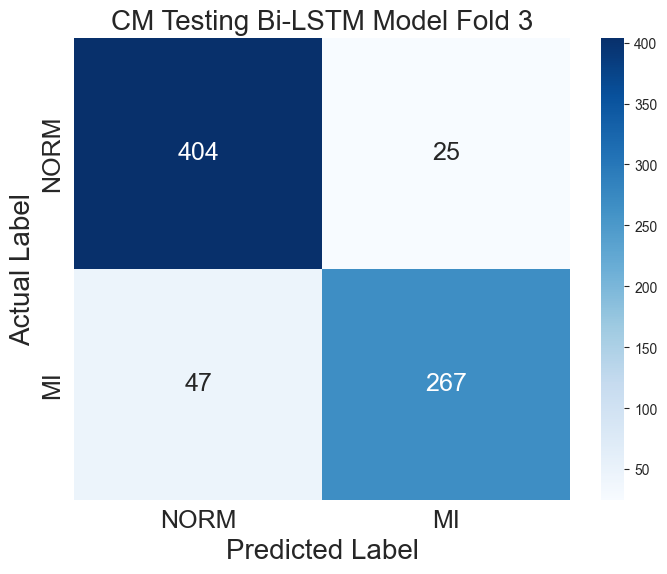


Processing Fold 4



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8211 - loss: 0.4303
Epoch 1: val_accuracy improved from -inf to 0.83383, saving model to modelResult/best_bi_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.8211 - loss: 0.4303 - val_accuracy: 0.8338 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8283 - loss: 0.4033
Epoch 2: val_accuracy improved from 0.83383 to 0.83907, saving model to modelResult/best_bi_lstm_model_fold_4.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.8283 - loss: 0.4033 - val_accuracy: 0.8391 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8395 - loss: 0.3811
Epoch 3: val_accuracy did not improve from 0.83907
335/335 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.8395 - loss: 0.3811 - val_accuracy: 0.7463 - val_loss: 0.5055 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━

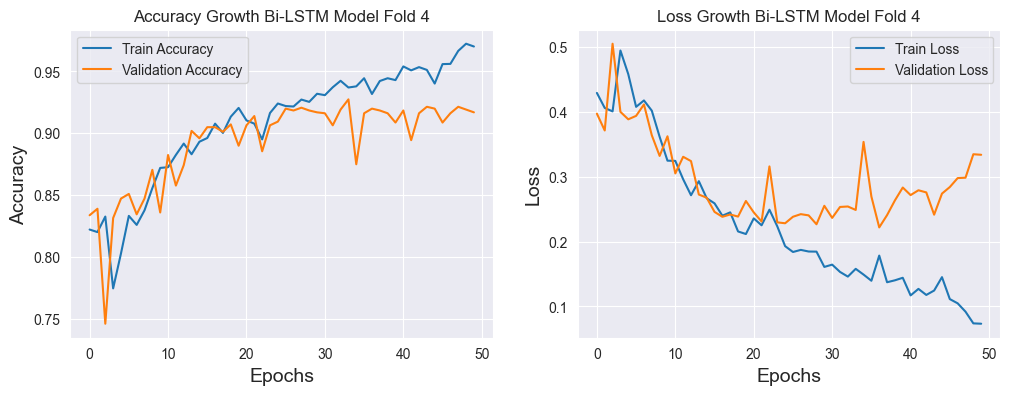

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 471ms/step - accuracy: 0.9005 - loss: 0.3701
Test Loss: 0.3900989294052124, Test Accuracy: 0.9098250269889832
168/168 ━━━━━━━━━━━━━━━━━━━━ 80s 475ms/step


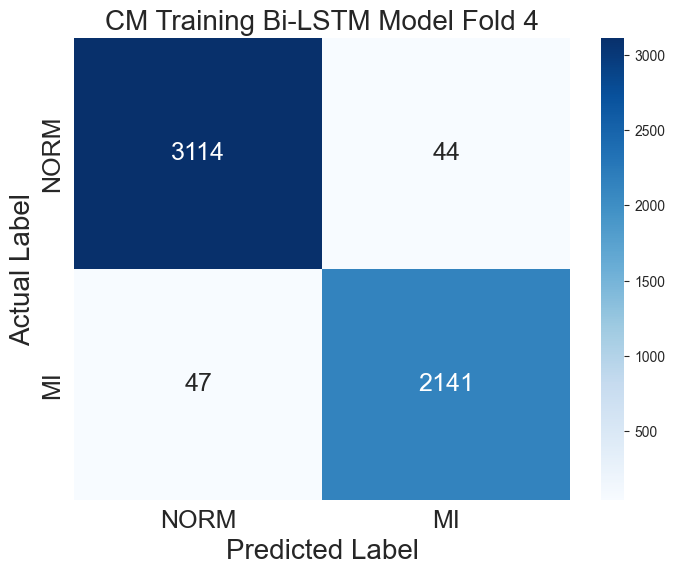

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step


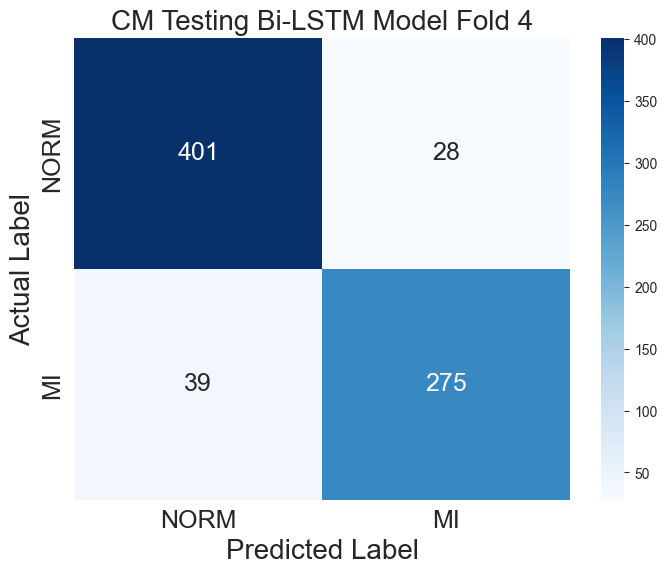


Processing Fold 5



Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8259 - loss: 0.4411
Epoch 1: val_accuracy improved from -inf to 0.84581, saving model to modelResult/best_bi_lstm_model_fold_5.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.8259 - loss: 0.4411 - val_accuracy: 0.8458 - val_loss: 0.3795 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7709 - loss: 0.4836
Epoch 2: val_accuracy did not improve from 0.84581
335/335 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.7710 - loss: 0.4836 - val_accuracy: 0.8114 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7959 - loss: 0.4669
Epoch 3: val_accuracy did not improve from 0.84581
335/335 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.7959 - loss: 0.4668 - val_accuracy: 0.8451 - val_loss: 0.3761 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8517 - loss: 0.3696
Epoch 4: val_accura

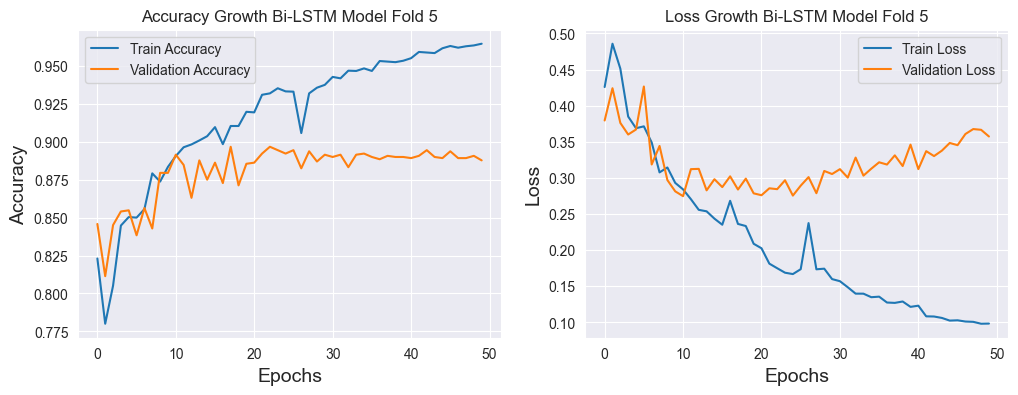

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 507ms/step - accuracy: 0.9042 - loss: 0.3522
Test Loss: 0.38380175828933716, Test Accuracy: 0.8990578651428223
168/168 ━━━━━━━━━━━━━━━━━━━━ 86s 509ms/step


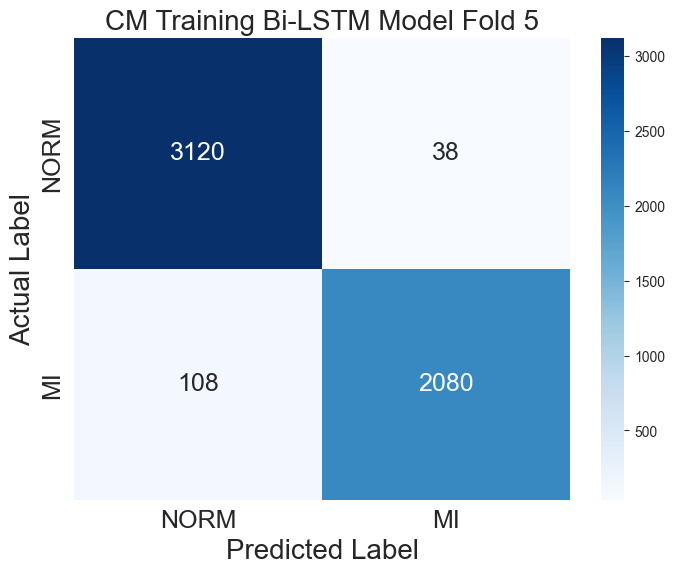

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step


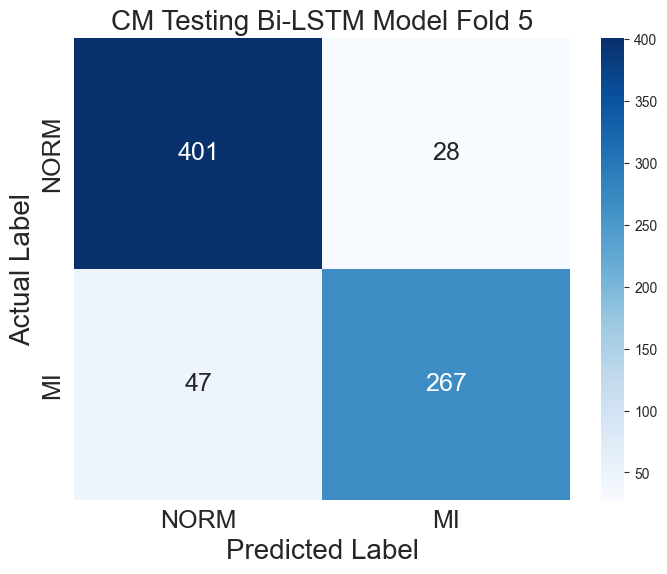


Cross-Validation Metrics Summary:
   fold  test_loss  test_accuracy
0     1   0.289180       0.903096
1     2   0.308456       0.885599
2     3   0.308050       0.903096
3     4   0.390099       0.909825
4     5   0.383802       0.899058

Average Validation Accuracy across all folds: 0.9001


In [19]:
# Placeholder untuk hasil fold
fold_metrics = []

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold = 0

# Load the pretrained Bi-LSTM model
pretrained_bi_lstm_model = load_model(bi_lstm_model_path)
pretrained_bi_lstm_model.summary()

# Gunakan parameter terbaik
learning_rate = best_param_bi_lstm['learning_rate']
batch_size = int(best_param_bi_lstm['batch_size'])

for train_index, valid_index in kf.split(X_train, np.argmax(y_train, axis=1)):
    fold += 1
    print(f"\nProcessing Fold {fold}\n")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Load pre-trained model for each fold
    pretrained_bi_lstm_model = load_model(bi_lstm_model_path)

    pretrained_bi_lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), 
                                     loss='categorical_crossentropy', 
                                     metrics=['accuracy'])
    
    # Step 5: Define Callbacks
    checkpoint = ModelCheckpoint(filepath=f'modelResult/best_bi_lstm_model_fold_{fold}.keras', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 verbose=1, 
                                 mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=10, 
                                  min_lr=0.000001, 
                                  verbose=1)

    # Step 6: Fine-tuning the new model on the current fold's training set
    history = pretrained_bi_lstm_model.fit(X_train_fold, y_train_fold, 
                        epochs=50, 
                        batch_size=batch_size, 
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=[checkpoint, reduce_lr], 
                        verbose=1)

    # Step 7: Plot accuracy and loss for the current fold
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Growth Bi-LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Growth Bi-LSTM Model Fold {fold}')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.savefig(f'image/training_history_bi_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Step 8: Evaluate model on the test set
    test_loss, test_accuracy = pretrained_bi_lstm_model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Save fold metrics
    fold_metrics.append({
        "fold": fold,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
    })

    # Step 9: Confusion Matrix on the training set
    y_train_pred = pretrained_bi_lstm_model.predict(X_train_fold)
    y_train_pred_classes = np.argmax(y_train_pred, axis=1)
    y_train_true_classes = np.argmax(y_train_fold, axis=1)
    
    cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot training confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Training Bi-LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_training_bi_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for training as CSV
    cm_train_df = pd.DataFrame(cm_train, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_train_df.to_csv(f'excel_output/confusion_matrix_training_bi_lstm_model_fold_{fold}.csv')

    # Step 9: Confusion Matrix on the test set
    y_test_pred = pretrained_bi_lstm_model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true_classes = np.argmax(y_test, axis=1)
    
    cm_test = confusion_matrix(y_test_true_classes, y_test_pred_classes)
    labels = ['NORM', 'MI']
    
    # Plot test confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 18})
    plt.title(f'CM Testing Bi-LSTM Model Fold {fold}', fontsize=20)
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'image/confusion_matrix_testing_bi_lstm_model_fold_{fold}.png', dpi=300)
    plt.show()
    plt.close()

    # Save confusion matrix for testing as CSV
    cm_test_df = pd.DataFrame(cm_test, index=['NORM', 'MI'], columns=['Predicted NORM', 'Predicted MI'])
    cm_test_df.to_csv(f'excel_output/confusion_matrix_testing_bi_lstm_model_fold_{fold}.csv')

# Step 10: Save the metrics summary
metrics_df = pd.DataFrame(fold_metrics)
metrics_df.to_csv('excel_output/fold_metrics_summary_bi_lstm_model.csv', index=False)

# Print out the summary of the metrics across all folds
print("\nCross-Validation Metrics Summary:")
print(metrics_df)

# Calculate and print the average accuracy across all folds
mean_accuracy = metrics_df['test_accuracy'].mean()
print(f"\nAverage Validation Accuracy across all folds: {mean_accuracy:.4f}")


# END
